<a href="https://colab.research.google.com/github/A1171/ColabNotebooks/blob/main/MMVB_shares_TP2_SL1_2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Библиотеки

In [ ]:
import numpy as np
import keras
from keras import regularizers
import datetime
from keras.models import Sequential
from keras import layers
#from keras.layers import Dense, Dropout, Activation,Conv1D,MaxPool1D,Flatten,LeakyReLU,concatenate
from keras import activations
#from keras.optimizers import SGD
#from keras.optimizers import adam
from keras.models import load_model
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn import metrics
import tensorflow as tf
import pickle
# Генератор выборки временных рядов
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer,StandardScaler,MinMaxScaler
import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Настройки парсинга и каталоги

In [ ]:
SequencyLen=32
#PredictForward=3
TrainRecordsCount=900000
TestRecordsCount=45000
RecordsStep=1
UseTime=False
UseMA=False
MakeT2=True
MakeT3=True
MakeT4=True
AllData=True
FileDir="drive/My Drive/NN/DiplShares/"#content/
HistoryFileDir="drive/My Drive/NN/DiplShares/"#content/

Листы с положением различных параметров во входных данных

In [ ]:
MACDFeatures=list(range(22,40))
MAFeatures=list(range(18,45))
VolFeatures=[12]#,17]
PriceFeatures=[8,9,10,11]#,13,14,15,16]
RSIFeatures=list(range(13,22))
TemplatesAmount=5
NClasses=3
MiddleClass=NClasses//2


Шаблоны классов классификатора. 

In [ ]:
def Template41(y_data_train2):#4 периода TP=0.2 SL=0.2
  if(y_data_train2[4]==1 and y_data_train2[3]>-1 and y_data_train2[2]>-1):
    return 1
  if(y_data_train2[4]==-1 and y_data_train2[3]<1 and y_data_train2[2]<1):# and y_data_train2[43]==-1
    return -1
  return 0
def Template41Profit(y_data_train2):#4 периода TP=0.2 SL=0.2
  BuyPr=y_data_train2[14]
  SellPr=-y_data_train2[14]
  return np.array([BuyPr,SellPr])
def Template51(y_data_train2):#4 периода TP=0.4 SL=0.2
  if(y_data_train2[24]==1 and y_data_train2[4]>-1 and y_data_train2[3]>-1 and y_data_train2[2]>-1):
    return 1
  if(y_data_train2[24]==-1 and y_data_train2[4]<1 and y_data_train2[3]<1 and y_data_train2[2]<1):# and y_data_train2[43]==-1
    return -1
  return 0
def Template51Profit(y_data_train2):#4 периода TP=0.4 SL=0.2
  BuyPr=y_data_train2[34]
  if(BuyPr<-0.5):BuyPr=-0.5
  SellPr=-y_data_train2[34]
  if(SellPr<-0.5):SellPr=-0.5
  return np.array([BuyPr,SellPr])
def Template61(y_data_train2):#4 периода TP=0.6 SL=0.2
  if(y_data_train2[44]==1 and y_data_train2[24]>-1 and y_data_train2[4]>-1 and y_data_train2[3]>-1 and y_data_train2[2]>-1):
    return 1
  if(y_data_train2[44]==-1 and y_data_train2[24]<1 and y_data_train2[4]<1 and y_data_train2[3]<1 and y_data_train2[2]<1):# and y_data_train2[43]==-1
    return -1
  return 0
def Template61Profit(y_data_train2):#4 периода TP=0.6 SL=0.2
  BuyPr=y_data_train2[54]
  if(BuyPr<-0.333):BuyPr=-0.333
  SellPr=-y_data_train2[54]
  if(SellPr<-0.333):SellPr=-0.333
  return np.array([BuyPr,SellPr])
#Результат торгов на интервале для проверки моделей
def TradeResult(Pred,ProfitArr,Border=0):
  Volume=0
  VolumeBuy=0
  VolumeSell=0
  Profit=0
  WinVolumeBuy=0
  LossVolumeBuy=0
  WinVolumeSell=0
  LossVolumeSell=0
  for i in range(len(Pred)):
    Res=np.argmax(Pred[i])
    Buy=Res==0 and Pred[i][0]>Pred[i][1]+Border[1] and Pred[i][0]>Pred[i][2]+Border[2]
    Sell=Res==2 and Pred[i][2]>Pred[i][1]+Border[1] and Pred[i][2]>Pred[i][0]+Border[0]
    if Buy:
      Volume+=abs(ProfitArr[i,0])
      VolumeBuy+=abs(ProfitArr[i,0])
      Profit+=ProfitArr[i,0]
      if ProfitArr[i,0]>0:
        WinVolumeBuy+=ProfitArr[i,0]
      else:
        LossVolumeBuy+=-ProfitArr[i,0]
    if Sell:
      Volume+=abs(ProfitArr[i,1])
      VolumeSell+=abs(ProfitArr[i,1])
      Profit+=ProfitArr[i,1]
      if ProfitArr[i,1]>0:
        WinVolumeSell+=ProfitArr[i,1]
      else:
        LossVolumeSell+=-ProfitArr[i,1]
  if LossVolumeBuy<=0:LossVolumeBuy=0.01
  if LossVolumeSell<=0:LossVolumeSell=0.01
  Recall=Volume/len(Pred)
  return Profit, Volume,VolumeBuy,VolumeSell, Recall, WinVolumeBuy, WinVolumeSell, LossVolumeBuy, LossVolumeSell

def TradeResult4(Predictions,ProfitArr,Borders):
  Volume=0
  VolumeBuy=0
  VolumeSell=0
  Profit=0
  WinVolumeBuy=0
  LossVolumeBuy=0
  WinVolumeSell=0
  LossVolumeSell=0
  for i in range(len(Predictions[0])):
    Buys=[]
    Sells=[]
    for k,Pred in enumerate(Predictions):
      Res=np.argmax(Pred[i])
      Buy=Res==0 and Pred[i][0]>Pred[i][1]+Borders[k][1] and Pred[i][0]>Pred[i][2]+Borders[k][2]
      Sell=Res==2 and Pred[i][2]>Pred[i][1]+Borders[k][1] and Pred[i][2]>Pred[i][0]+Borders[k][0]
      Buys.append(Buy)
      Sells.append(Sell)
    Buys=np.array(Buys)
    Sells=np.array(Sells)
    ResBuy=np.all(Buys)
    ResSell=np.all(Sells)
    if ResBuy:#Buy1 and Buy2 and Buy3 and Buy4:
      Volume+=abs(ProfitArr[i,0])
      VolumeBuy+=abs(ProfitArr[i,0])
      Profit+=ProfitArr[i,0]
      if ProfitArr[i,0]>0:
        WinVolumeBuy+=ProfitArr[i,0]
      else:
        LossVolumeBuy+=-ProfitArr[i,0]
    if ResSell:#Sell1 and Sell2 and Sell3 and Sell4:
      Volume+=abs(ProfitArr[i,1])
      VolumeSell+=abs(ProfitArr[i,1])
      Profit+=ProfitArr[i,1]
      if ProfitArr[i,1]>0:
        WinVolumeSell+=ProfitArr[i,1]
      else:
        LossVolumeSell+=-ProfitArr[i,1]
  if LossVolumeBuy<=0:LossVolumeBuy=0.01
  if LossVolumeSell<=0:LossVolumeSell=0.01
  Recall=Volume/len(Predictions[0])
  return Profit, Volume,VolumeBuy,VolumeSell, Recall, WinVolumeBuy, WinVolumeSell, LossVolumeBuy, LossVolumeSell








In [ ]:
def my_loss_fn2(y_true, y_pred):
    selectedClassTr=y_true#K.softmax(y_true,axis=-1)
    selectedClassPr=y_pred#K.softmax(y_pred,axis=-1)
    return keras.losses.categorical_crossentropy(selectedClassTr,selectedClassPr)

Модели

In [ ]:
def Dense1(Shape1,Neurons1):
  inputs1 = keras.Input(shape=Shape1)
  x1 = layers.Flatten()(inputs1)
  x1 = layers.Dense(Neurons1, activation='tanh')(x1)
  x1 = layers.Dense(3, activation='softmax')(x1)
  return keras.Model(inputs=inputs1, outputs=x1)
def Dense2(Shape1,Neurons1,Neurons2):
  inputs1 = keras.Input(shape=Shape1)
  x1 = layers.Flatten()(inputs1)
  x1 = layers.Dense(Neurons1, activation='tanh')(x1)
  x1 = layers.Dense(Neurons2, activation='tanh')(x1)
  x1 = layers.Dense(3, activation='softmax')(x1)
  return keras.Model(inputs=inputs1, outputs=x1)

def ModelConvDense1(Shape1,Filters):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(x1)])
  x1 = layers.Dense(3, activation='softmax')(x1)
  return keras.Model(inputs=inputs1, outputs=x1)
def ModelConvDense2(Shape1,Neurons,Filters):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(x1)])
  x1 = layers.Dense(Neurons, activation='tanh')(x1)
  x1 = layers.Dense(3, activation='softmax')(x1)
  return keras.Model(inputs=inputs1, outputs=x1)
def ModelConv1(Shape1,Filters):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x1 = layers.Flatten()(x1)
  x1 = layers.Dense(3, activation='softmax')(x1)
  return keras.Model(inputs=inputs1, outputs=x1)
def ModelConv2(Shape1,Neurons,Filters):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x1 = layers.Flatten()(x1)
  x1 = layers.Dense(Neurons, activation='tanh')(x1)
  x1 = layers.Dense(3, activation='softmax')(x1)
  return keras.Model(inputs=inputs1, outputs=x1)

def ModelLSTM(Shape1,Neurons,LSTMSize):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.0005
  l2ConvB=0.0005
  l2DenseB=0.0005
  x = layers.LSTM(LSTMSize,return_sequences=False)(inputs1)
  x = layers.Dense(Neurons, activation='tanh', kernel_regularizer=regularizers.l2(l2Dense))(x)
  x = layers.Dense(3, activation='softmax')(x)
  return keras.Model(inputs=inputs1, outputs=x)

def Model3ConvDense1(Shape1,Shape2,Shape3,Shape4,Neurons,Filters,OutActivation='sigmoid'):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  inputs3 = keras.Input(shape=Shape3)
  inputs4 = keras.Input(shape=Shape4)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x2 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs2)
  x3 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs3)
  x4 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs4)
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(inputs2),layers.Flatten()(inputs3),layers.Flatten()(inputs4),layers.Flatten()(x1),layers.Flatten()(x2),layers.Flatten()(x3),layers.Flatten()(x4)])
  x1 = layers.Dense(3, activation=OutActivation)(x1)
  return keras.Model(inputs=[inputs1,inputs2,inputs3,inputs4], outputs=x1)
def Model3ConvDense1_2In(Shape1,Shape2,Neurons,Filters,OutActivation='sigmoid'):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x2 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs2)
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(inputs2),layers.Flatten()(x1),layers.Flatten()(x2)])
  x1 = layers.Dense(3, activation=OutActivation)(x1)
  return keras.Model(inputs=[inputs1,inputs2], outputs=x1)
def Model3ConvDense1_3In(Shape1,Shape2,Shape3,Neurons,Filters,OutActivation='sigmoid'):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  inputs3 = keras.Input(shape=Shape3)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x2 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs2)
  x3 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs3)
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(inputs2),layers.Flatten()(inputs3),layers.Flatten()(x1),layers.Flatten()(x2),layers.Flatten()(x3)])
  x1 = layers.Dense(3, activation=OutActivation)(x1)
  return keras.Model(inputs=[inputs1,inputs2,inputs3], outputs=x1)

def Model3ConvDense2(Shape1,Shape2,Shape3,Shape4,Neurons,Filters,OutActivation='sigmoid'):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  inputs3 = keras.Input(shape=Shape3)
  inputs4 = keras.Input(shape=Shape4)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x2 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs2)
  x3 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs3)
  x4 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs4)
  x11 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x21 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x2)
  x31 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x3)
  x41 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x4)
  x1= layers.Flatten()(x1)
  x2= layers.Flatten()(x2)
  x3= layers.Flatten()(x3)
  x4= layers.Flatten()(x4)
  x11= layers.Flatten()(x11)
  x21= layers.Flatten()(x21)
  x31= layers.Flatten()(x31)
  x41= layers.Flatten()(x41)
  
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(inputs2),layers.Flatten()(inputs3),layers.Flatten()(inputs4),x1,x2,x3,x4,x11,x21,x31,x41])
  x1 = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x1 = layers.Dropout(0.5)(x1)
  x1 = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x1 = layers.Dense(3, activation=OutActivation)(x1)
  return keras.Model(inputs=[inputs1,inputs2,inputs3,inputs4], outputs=x1)
def Model3ConvDense2_3In(Shape1,Shape2,Shape3,Neurons,Filters,OutActivation='sigmoid'):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  inputs3 = keras.Input(shape=Shape3)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x2 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs2)
  x3 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs3)
  x11 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x21 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x2)
  x31 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x3)
  x1= layers.Flatten()(x1)
  x2= layers.Flatten()(x2)
  x3= layers.Flatten()(x3)
  x11= layers.Flatten()(x11)
  x21= layers.Flatten()(x21)
  x31= layers.Flatten()(x31)
  
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(inputs2),layers.Flatten()(inputs3),x1,x2,x3,x11,x21,x31])
  x1 = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x1 = layers.Dropout(0.5)(x1)
  x1 = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x1 = layers.Dense(3, activation=OutActivation)(x1)
  return keras.Model(inputs=[inputs1,inputs2,inputs3], outputs=x1)
def Model3ConvDense2_2In(Shape1,Shape2,Neurons,Filters,OutActivation='sigmoid'):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x2 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs2)
  x11 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x21 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Conv),bias_regularizer=regularizers.l2(l2ConvB),activity_regularizer=regularizers.l1(lambdaActivity1))(x2)
  x1= layers.Flatten()(x1)
  x2= layers.Flatten()(x2)
  x11= layers.Flatten()(x11)
  x21= layers.Flatten()(x21)
  
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(inputs2),x1,x2,x11,x21])
  x1 = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x1 = layers.Dropout(0.5)(x1)
  x1 = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x1 = layers.Dense(3, activation=OutActivation)(x1)
  return keras.Model(inputs=[inputs1,inputs2], outputs=x1)
def ModelConvDense11(Shape1,Neurons,Filters):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x2 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x1)
  x3 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x2)
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(x1),layers.Flatten()(x2),layers.Flatten()(x3)])
  x1 = layers.Dense(3, activation='softmax')(x1)
  return keras.Model(inputs=inputs1, outputs=x1)
#Гибкая до 5 входов сверточная
def create_Conv_short4In(Shape1,Shape2,Shape3,Shape4,Shape5,Neurons,Filters,l2Conv=0.0005,NumOut=4,UseTimeAdd=False):
  inputs1 = keras.Input(shape=Shape1)
  inputs2 = keras.Input(shape=Shape2)
  if(Shape3!=None):
    inputs3 = keras.Input(shape=Shape3)
  if(Shape4!=None):
    inputs4 = keras.Input(shape=Shape4)
  if(Shape5!=None):
    inputs5 = keras.Input(shape=Shape5)
  TimeData2 = inputs1[...,-1,32:]
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Dense=0.001
  l2DenseB=0.001
  x = layers.Conv1D(Filters,3,strides=2, padding='same',use_bias=True, kernel_regularizer=regularizers.l2(l2Conv))(inputs1)
  x = layers.LeakyReLU(alpha=0.1)(x)
  x = layers.Conv1D(Filters*2,3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x)
  x = layers.BatchNormalization(epsilon=0.001)(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  x = layers.Conv1D(Filters*4,3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x)
  x = layers.BatchNormalization(epsilon=0.001)(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  #x = layers.Conv1D(Filters*8,3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x)
  #x = layers.BatchNormalization(epsilon=0.001)(x)
  #x = layers.LeakyReLU(alpha=0.1)(x)
  x = layers.Conv1D(Filters*8,3,strides=1, padding='valid',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x)
  x = layers.BatchNormalization(epsilon=0.001)(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  x = layers.Flatten()(x)

  x1 = layers.Conv1D(int(Filters),3,strides=2, padding='same',use_bias=True, kernel_regularizer=regularizers.l2(l2Conv))(inputs2)
  x1 = layers.LeakyReLU(alpha=0.1)(x1)
  x1 = layers.Conv1D(int(Filters*2),3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x1)
  x1 = layers.BatchNormalization(epsilon=0.001)(x1)
  x1 = layers.LeakyReLU(alpha=0.1)(x1)
  x1 = layers.Conv1D(int(Filters*4),3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x1)
  x1 = layers.BatchNormalization(epsilon=0.001)(x1)
  x1 = layers.LeakyReLU(alpha=0.1)(x1)
  #x1 = layers.Conv1D(Filters*8,3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x1)
  #x1 = layers.BatchNormalization(epsilon=0.001)(x1)
  #x1 = layers.LeakyReLU(alpha=0.1)(x1)
  x1 = layers.Conv1D(int(Filters*8),3,strides=1, padding='valid',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x1)
  x1 = layers.BatchNormalization(epsilon=0.001)(x1)
  x1 = layers.LeakyReLU(alpha=0.1)(x1)
  x1 = layers.Flatten()(x1)
  if(Shape3!=None):
    x2 = layers.Conv1D(int(Filters),3,strides=2, padding='same',use_bias=True, kernel_regularizer=regularizers.l2(l2Conv))(inputs3)
    x2 = layers.LeakyReLU(alpha=0.1)(x2)
    x2 = layers.Conv1D(int(Filters*2),3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x2)
    x2 = layers.BatchNormalization(epsilon=0.001)(x2)
    x2 = layers.LeakyReLU(alpha=0.1)(x2)
    x2 = layers.Conv1D(int(Filters*4),3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x2)
    x2 = layers.BatchNormalization(epsilon=0.001)(x2)
    x2 = layers.LeakyReLU(alpha=0.1)(x2)
    #x2 = layers.Conv1D(int(Filters*8*0.7),3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x2)
    #x2 = layers.BatchNormalization(epsilon=0.001)(x2)
    #x2 = layers.LeakyReLU(alpha=0.1)(x2)
    x2 = layers.Conv1D(int(Filters*8),3,strides=1, padding='valid',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x2)
    x2 = layers.BatchNormalization(epsilon=0.001)(x2)
    x2 = layers.LeakyReLU(alpha=0.1)(x2)
    x2 = layers.Flatten()(x2)

  if(Shape4!=None):
    x3 = layers.Conv1D(int(Filters),3,strides=2, padding='same',use_bias=True, kernel_regularizer=regularizers.l2(l2Conv))(inputs4)
    x3 = layers.LeakyReLU(alpha=0.1)(x3)
    x3 = layers.Conv1D(int(Filters*2),3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x3)
    x3 = layers.BatchNormalization(epsilon=0.001)(x3)
    x3 = layers.LeakyReLU(alpha=0.1)(x3)
    x3 = layers.Conv1D(int(Filters*4),3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x3)
    x3 = layers.BatchNormalization(epsilon=0.001)(x3)
    x3 = layers.LeakyReLU(alpha=0.1)(x3)
    #x3 = layers.Conv1D(int(Filters*8*0.5),3,strides=2, padding='same',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x3)
    #x3 = layers.BatchNormalization(epsilon=0.001)(x3)
    #x3 = layers.LeakyReLU(alpha=0.1)(x3)
    x3 = layers.Conv1D(int(Filters*8),3,strides=1, padding='valid',use_bias=False, kernel_regularizer=regularizers.l2(l2Conv))(x3)
    x3 = layers.BatchNormalization(epsilon=0.001)(x3)
    x3 = layers.LeakyReLU(alpha=0.1)(x3)
    x3 = layers.Flatten()(x3)
  if(Shape3!=None and Shape4!=None):
    x = layers.Concatenate()([x,x1,x2,x3])
  elif(Shape3!=None and Shape4==None):
    x = layers.Concatenate()([x,x1,x2])
  elif(Shape3==None and Shape4!=None):
    x = layers.Concatenate()([x,x1,x3])
  elif(Shape3==None and Shape4==None):
    x = layers.Concatenate()([x,x1])
  if(Shape5!=None):
    x = layers.Concatenate()([x,inputs5])
  if(UseTimeAdd):
    x = layers.Concatenate()([x,layers.Flatten()(TimeData2)])
    
  x = layers.Dense(Neurons, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(NumOut, activation='softmax')(x)
  if(Shape5==None):
    if(Shape3!=None and Shape4!=None):
      Model=keras.Model(inputs=[inputs1,inputs2,inputs3,inputs4], outputs=x)
    elif(Shape3!=None and Shape4==None):
      Model=keras.Model(inputs=[inputs1,inputs2,inputs3], outputs=x)
    elif(Shape3==None and Shape4!=None):
      Model=keras.Model(inputs=[inputs1,inputs2,inputs4], outputs=x)
    elif(Shape3==None and Shape4==None):
      Model=keras.Model(inputs=[inputs1,inputs2], outputs=x)
  else:
    if(Shape3!=None and Shape4!=None):
      Model=keras.Model(inputs=[inputs1,inputs2,inputs3,inputs4,inputs5], outputs=x)
    elif(Shape3!=None and Shape4==None):
      Model=keras.Model(inputs=[inputs1,inputs2,inputs3,inputs5], outputs=x)
    elif(Shape3==None and Shape4!=None):
      Model=keras.Model(inputs=[inputs1,inputs2,inputs4,inputs5], outputs=x)
    elif(Shape3==None and Shape4==None):
      Model=keras.Model(inputs=[inputs1,inputs2,inputs5], outputs=x)
  return Model




In [ ]:
#Парсинг данных Создание 4 последовательностей цены. Исходные данные 5 минутки, добавим склееные данные
def GetTrainArrays4(x_data_tr,y_in_data_tr,BinalizerDOW,BinalizerHour,BinalizerMin,BinalizerRSI):
  #Время пропустим через биналайзеры, чтобы получить метку времени как набор 0 и 1
  if(UseTime):
    Time_Bin_tr=[]
    if(NoDOW):
        if(x_data_tr.shape[0]>0):Time_Bin_tr=np.hstack((BinalizerHour.transform(np.array((x_data_tr[:,HourPos]+0.1),dtype=int)),BinalizerMin.transform(np.array((x_data_tr[:,MinPos]+0.1),dtype=int))))
    else:
        if(x_data_tr.shape[0]>0):Time_Bin_tr=np.hstack((BinalizerDOW.transform(np.array((x_data_tr[:,DOWPos]+0.1),dtype=int)),BinalizerHour.transform(np.array((x_data_tr[:,HourPos]+0.1),dtype=int)),BinalizerMin.transform(np.array((x_data_tr[:,MinPos]+0.1),dtype=int))))
  if(UseMA):
    x_data_tr2=np.hstack((x_data_tr[:,PriceFeatures],x_data_tr[:,MAFeatures],x_data_tr[:,MACDFeatures],x_data_tr[:,VolFeatures],x_data_tr[:,RSIFeatures]))
    NewVolPos=len(PriceFeatures)+len(MAFeatures)+len(MACDFeatures)

  else:
    #x_data_tr2=np.hstack((x_data_tr[:,PriceFeatures],x_data_tr[:,MACDFeatures],x_data_tr[:,VolFeatures],x_data_tr[:,RSIFeatures]))
    x_data_tr2=np.hstack((x_data_tr[:,PriceFeatures],x_data_tr[:,MACDFeatures],x_data_tr[:,RSIFeatures],x_data_tr[:,VolFeatures]))
    MACDStart=len(PriceFeatures)
    MACDStop=MACDStart+len(MACDFeatures)
    NewVolPos=len(PriceFeatures)+len(MACDFeatures)+len(RSIFeatures)
  ClosePos=3
  #Добавим изменение цены по сравнению с предыдущим закрытием
  x_data_tr2_price_delta=x_data_tr2[1:,:len(PriceFeatures)].copy()-x_data_tr2[:-1,ClosePos].copy().reshape(-1,1)
  #print("tr1",len(PriceFeatures),len(MACDFeatures),len(RSIFeatures),len(VolFeatures),x_data_tr2.shape,x_data_tr2_price_delta.shape,Time_Bin_tr.shape)
  
  x_data_tr2=x_data_tr2[1:]
  if(type(y_in_data_tr)!=type(None)):y_in_data_tr=y_in_data_tr[1:]
  PriceDeltaStart=x_data_tr2.shape[1]
  PriceDeltaStop=PriceDeltaStart+x_data_tr2_price_delta.shape[1]
  #Стыкуем данные метки времени заменили на последовательности 0 1, и добавили изменение цены
  if(UseTime):
    Time_Bin_tr=Time_Bin_tr[1:]
    x_data_tr2=np.hstack((x_data_tr2,x_data_tr2_price_delta,Time_Bin_tr))
  else:
    x_data_tr2=np.hstack((x_data_tr2,x_data_tr2_price_delta))

  #новые списки с позициями цены в новых последовательностях
  if(UseMA):
    NewPriceRelatedFeatures=list(range(len(MAFeatures)+len(PriceFeatures)))
  else:
    NewPriceRelatedFeatures=list(range(len(PriceFeatures)))

  
  TFMul=3#множитель времени чтобы получить 15,45,135 минутки
  TrTestStart=(TFMul**3)*(SequencyLen+1)+1
  STDScaleLen=(TFMul**3)*(SequencyLen)
  TrainStop=len(x_data_tr2)
  print("TrTestStart ",TrTestStart,TrainStop)
  
  #пустые списки для временных последовательностей
  x_data_train_t1=[]
  x_data_train_t2=[]
  x_data_train_t3=[]
  x_data_train_t4=[]
  y_in_data_train2=[]
  #MACDStd=x_data_tr2[:,MACDStart:MACDStop].std(axis=0)
  for i in range(TrTestStart,TrainStop+1,RecordsStep):
    k=NewVolPos
    VolMax2=np.amax(x_data_tr2[i-SequencyLen:i,k])
    VolMax=VolMax2.copy()
    PriceMax2=np.amax(x_data_tr2[i-SequencyLen:i,PriceDeltaStart:PriceDeltaStop])
    PriceMax=PriceMax2.copy()
    VolMin2=np.amin(x_data_tr2[i-SequencyLen:i,k])
    VolMin=VolMin2.copy()
    PriceMin2=np.amin(x_data_tr2[i-SequencyLen:i,PriceDeltaStart:PriceDeltaStop])
    PriceMin=PriceMin2.copy()
    MACDMin2=np.amin(x_data_tr2[i-STDScaleLen:i,MACDStart:MACDStop],axis=0)
    MACDMin=MACDMin2.copy()
    MACDMax2=np.amax(x_data_tr2[i-STDScaleLen:i,MACDStart:MACDStop],axis=0)#.reshape(1,-1)
    MACDMax=MACDMax2.copy()
    MACDMax[MACDMax-MACDMin<=0]=0.0001
    PriceStd1=x_data_tr2[i-SequencyLen:i,PriceDeltaStart:PriceDeltaStop].std()
    PriceDeltaMin=max(PriceStd1/10,0.001)
    if (VolMax-VolMin<1):VolMax=VolMin+1
    if (PriceMax-PriceMin<PriceDeltaMin):PriceMax=PriceMin+PriceDeltaMin

    Vol1Std=0.5    
    x_data_train_t1.append(x_data_tr2[i-SequencyLen:i].copy())
    x_data_train_t1[-1][:,k]=(x_data_train_t1[-1][:,k]-VolMin)/(VolMax-VolMin)
    x_data_train_t1[-1][:,PriceDeltaStart:PriceDeltaStop]=(x_data_train_t1[-1][:,PriceDeltaStart:PriceDeltaStop]-PriceMin)/(PriceMax-PriceMin)
    x_data_train_t1[-1][:,MACDStart:MACDStop]=(x_data_train_t1[-1][:,MACDStart:MACDStop]-MACDMin.reshape(1,-1))/((MACDMax-MACDMin).reshape(1,-1))
    if(type(y_in_data_tr)!=type(None)):y_in_data_train2.append(y_in_data_tr[i-1])
    T2_Record=[]
    T3_Record=[]
    T4_Record=[]
    for j in range(SequencyLen):
      EndPos=i-j*TFMul
      StPos=i-j*TFMul-TFMul
      T2_Record.append([x_data_tr2[StPos,0].copy(),np.amax(x_data_tr2[StPos:EndPos,:4]),np.amin(x_data_tr2[StPos:EndPos,:4]),x_data_tr2[EndPos-1,3].copy(),np.sum(x_data_tr2[StPos:EndPos,NewVolPos])/Vol1Std/2/TFMul])
      EndPos=i-j*TFMul*TFMul
      StPos=i-j*TFMul*TFMul-TFMul*TFMul
      T3_Record.append([x_data_tr2[StPos,0].copy(),np.amax(x_data_tr2[StPos:EndPos,:4]),np.amin(x_data_tr2[StPos:EndPos,:4]),x_data_tr2[EndPos-1,3].copy(),np.sum(x_data_tr2[StPos:EndPos,NewVolPos])/Vol1Std/2/TFMul/TFMul])
      EndPos=i-j*TFMul*TFMul*TFMul
      StPos=i-j*TFMul*TFMul*TFMul-TFMul*TFMul*TFMul
      T4_Record.append([x_data_tr2[StPos,0].copy(),np.amax(x_data_tr2[StPos:EndPos,:4]),np.amin(x_data_tr2[StPos:EndPos,:4]),x_data_tr2[EndPos-1,3].copy(),np.sum(x_data_tr2[StPos:EndPos,NewVolPos])/Vol1Std/2/TFMul/TFMul/TFMul])
    if(MakeT2):
      x_data_train_t2.append(np.array(T2_Record))
      VolMax_t2=np.amax(x_data_train_t2[-1][:,4])
      VolMin_t2=np.amin(x_data_train_t2[-1][:,4])
      if (VolMax_t2-VolMin_t2<1):VolMax_t2=VolMin_t2+1
      x_data_train_t2[-1][:,4]=(x_data_train_t2[-1][:,4]-VolMin_t2)/(VolMax_t2-VolMin_t2)
      
    
    if(MakeT3):
      x_data_train_t3.append(np.array(T3_Record))
      VolMax_t3=np.amax(x_data_train_t3[-1][:,4])
      VolMin_t3=np.amin(x_data_train_t3[-1][:,4])
      if (VolMax_t3-VolMin_t3<1):VolMax_t3=VolMin_t3+1
      x_data_train_t3[-1][:,4]=(x_data_train_t3[-1][:,4]-VolMin_t3)/(VolMax_t3-VolMin_t3)
      
    if(MakeT4):
      x_data_train_t4.append(np.array(T4_Record))
      VolMax_t4=np.amax(x_data_train_t4[-1][:,4])
      VolMin_t4=np.amin(x_data_train_t4[-1][:,4])
      if (VolMax_t4-VolMin_t4<1):VolMax_t4=VolMin_t4+1
      x_data_train_t4[-1][:,4]=(x_data_train_t4[-1][:,4]-VolMin_t4)/(VolMax_t4-VolMin_t4)
    
    
  #print("sd",NewVolPos,PriceDeltaStart,PriceDeltaStop)
  x_data_train_t1=np.array(x_data_train_t1)
  x_data_train_t2=np.array(x_data_train_t2)
  x_data_train_t3=np.array(x_data_train_t3)
  x_data_train_t4=np.array(x_data_train_t4)
  if(type(y_in_data_tr)!=type(None)):y_in_data_train2=np.array(y_in_data_train2)
  print(x_data_train_t1.shape)
  print(x_data_train_t2.shape)
  print(x_data_train_t3.shape)
  print(x_data_train_t4.shape)
  if(type(y_in_data_tr)!=type(None)):print(y_in_data_train2.shape)

  PriceScaleMiMax=list(range(4))
  #PriceScaleMiMax=NewPriceRelatedFeatures
  MaxPrice=np.amax(np.amax(x_data_train_t1[:,:,PriceScaleMiMax],axis=-1),axis=-1)
  MinPrice=np.amin(np.amin(x_data_train_t1[:,:,PriceScaleMiMax],axis=-1),axis=-1)
  MaxPrice[MaxPrice-MinPrice<0.001]=MinPrice[MaxPrice-MinPrice<0.001]+0.001
  x_data_train_t1[:,:,NewPriceRelatedFeatures]=(x_data_train_t1[:,:,NewPriceRelatedFeatures]-MinPrice.reshape(-1,1,1))/(MaxPrice-MinPrice).reshape(-1,1,1)*2-1
  #if(type(y_in_data_tr)!=type(None)):y_data_train_t1=y_data_train_t1/(MaxPrice-MinPrice).reshape(-1,1,1)*2

  PriceScaleMiMax=list(range(4))
  if(MakeT2):
    MaxPrice=np.amax(np.amax(x_data_train_t2[:,:,PriceScaleMiMax],axis=-1),axis=-1)
    MinPrice=np.amin(np.amin(x_data_train_t2[:,:,PriceScaleMiMax],axis=-1),axis=-1)
    MaxPrice[MaxPrice-MinPrice<0.001]=MinPrice[MaxPrice-MinPrice<0.001]+0.001
    x_data_train_t2[:,:,PriceScaleMiMax]=(x_data_train_t2[:,:,PriceScaleMiMax]-MinPrice.reshape(-1,1,1))/(MaxPrice-MinPrice).reshape(-1,1,1)*2-1
  if(MakeT3):
    MaxPrice=np.amax(np.amax(x_data_train_t3[:,:,PriceScaleMiMax],axis=-1),axis=-1)
    MinPrice=np.amin(np.amin(x_data_train_t3[:,:,PriceScaleMiMax],axis=-1),axis=-1)
    MaxPrice[MaxPrice-MinPrice<0.001]=MinPrice[MaxPrice-MinPrice<0.001]+0.001
    x_data_train_t3[:,:,PriceScaleMiMax]=(x_data_train_t3[:,:,PriceScaleMiMax]-MinPrice.reshape(-1,1,1))/(MaxPrice-MinPrice).reshape(-1,1,1)*2-1
  if(MakeT4):
    MaxPrice=np.amax(np.amax(x_data_train_t4[:,:,PriceScaleMiMax],axis=-1),axis=-1)
    MinPrice=np.amin(np.amin(x_data_train_t4[:,:,PriceScaleMiMax],axis=-1),axis=-1)
    MaxPrice[MaxPrice-MinPrice<0.001]=MinPrice[MaxPrice-MinPrice<0.001]+0.001
    x_data_train_t4[:,:,PriceScaleMiMax]=(x_data_train_t4[:,:,PriceScaleMiMax]-MinPrice.reshape(-1,1,1))/(MaxPrice-MinPrice).reshape(-1,1,1)*2-1

  TemplTr=[]
  TemplTrPr=[]
  WeightMatrix=0
  WeightMatrix2=0
  if(type(y_in_data_tr)!=type(None)):
    for i in range(y_in_data_train2.shape[0]):
      TemplTr.append(Template51(y_in_data_train2[i]))
      TemplTrPr.append(Template51Profit(y_in_data_train2[i]))

    TemplTr=np.array(TemplTr)
    TemplTrPr=np.array(TemplTrPr)
  #как вариант закладывал возможность создать до 7 классов будущего движения цены для деления движений на сильные и
  #слабые, в результате получилось что достаточно 3 класса уйдет вверх уйдет вниз, останется на месте
    Classes1=len(TemplTr[TemplTr==3])
    Classes2=len(TemplTr[TemplTr==2])
    Classes3=len(TemplTr[TemplTr==1])
    Classes4=len(TemplTr[TemplTr==0])
    Classes5=len(TemplTr[TemplTr==-1])
    Classes6=len(TemplTr[TemplTr==-2])
    Classes7=len(TemplTr[TemplTr==-3])
    if(NClasses==7):WeightMatrix=[1/Classes1,1/Classes2,1/Classes3,1/Classes4,1/Classes5,1/Classes6,1/Classes7]
    if(NClasses==5):WeightMatrix=[1/Classes2,1/Classes3,1/Classes4,1/Classes5,1/Classes6]
    if(NClasses==3):WeightMatrix=[1/Classes3,1/Classes4,1/Classes5]
    WeightMatrix=np.array(WeightMatrix)/np.amax(WeightMatrix)
    Multiplier=np.sum(1/WeightMatrix)/len(WeightMatrix)
    WeightMatrix=WeightMatrix*Multiplier
    #WeightMatrixSumm.append([*WeightMatrix,0,0])
    #print(i,"Template ",TemplteDescriptionList[i])
    print(Classes1,Classes2,Classes3,Classes4,Classes5,Classes6,Classes7)
    #print(len(TemplTest[TemplTest==1]),len(TemplTest[TemplTest==-1]),len(TemplTest[TemplTest==0]))
    WeightMatrix2=dict(enumerate(WeightMatrix.flatten(), 0))

    y_data_train_tpl=np.zeros((y_in_data_train2.shape[0],NClasses))

    y_data_train_tpl[np.where(TemplTr==1),MiddleClass-1]=1
    y_data_train_tpl[np.where(TemplTr==0),MiddleClass]=1
    y_data_train_tpl[np.where(TemplTr==-1),MiddleClass+1]=1
    if(NClasses>3):
      y_data_train_tpl[np.where(TemplTr==2),MiddleClass-2]=1
      y_data_train_tpl[np.where(TemplTr==-2),MiddleClass+2]=1
    if(NClasses>5):
      y_data_train_tpl[np.where(TemplTr==3),MiddleClass-3]=1
      y_data_train_tpl[np.where(TemplTr==-3),MiddleClass+3]=1
    
  return TemplTrPr,x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4,y_data_train_tpl,WeightMatrix2,WeightMatrix



Склейка акций если выбранно более 1 акции и разбивка на проверочную и тестовую выборки.

In [ ]:
#Сначала попробуем все для одной акции и колаб скорее всего больше одой не потянет
AdditNames=["SBER_M5_Linear5"]#,"GAZP_M5_Linear2","GMKN_M5_Linear2","LKOH_M5_Linear2","ALRS_M5_Linear2","ROSN_M5_Linear2","VTBR_M5_Linear2","PLZL_M5_Linear2","MGNT_M5_Linear2","SIBN_M5_Linear2","SNGS_M5_Linear2"]
x_data_tr=[]
x_data_test=[]
y_in_data_tr=[]
y_in_data_test=[]

x_data_tr_share=[]
x_data_test_share=[]
y_in_data_tr_share=[]
y_in_data_test_share=[]

TrainTestGap=SequencyLen*(3**3)
TestFromEnd=True
for Name in AdditNames:
  x_data_1 = np.loadtxt(HistoryFileDir+"DataFileI1_"+Name+'.txt')
  y_data_1 = np.loadtxt(HistoryFileDir+"DataFileO1_"+Name+'.txt')
  RecordsCnt=len(x_data_1)
  TrainRecords=int(RecordsCnt*0.95)
  if(TestFromEnd):
    x_data_tr_share.append(x_data_1[:TrainRecords].copy())
    y_in_data_tr_share.append(y_data_1[:TrainRecords].copy())
    x_data_test_share.append(x_data_1[TrainRecords+TrainTestGap:].copy())
    y_in_data_test_share.append(y_data_1[TrainRecords+TrainTestGap:].copy())
  else:
    x_data_tr_share.append(x_data_1[-TrainRecords:].copy())
    y_in_data_tr_share.append(y_data_1[-TrainRecords:].copy())
    x_data_test_share.append(x_data_1[:-TrainRecords-TrainTestGap].copy())
    y_in_data_test_share.append(y_data_1[:-TrainRecords-TrainTestGap].copy())
  print(Name,len(x_data_1))
  if(len(x_data_tr)==0):
    x_data_tr=x_data_1[:TrainRecords].copy()
    x_data_test=x_data_1[TrainRecords+TrainTestGap:].copy()
    y_in_data_tr=y_data_1[:TrainRecords].copy()
    y_in_data_test=y_data_1[TrainRecords+TrainTestGap:].copy()
  else:
    if(TestFromEnd):
      x_data_tr=np.vstack((x_data_tr,x_data_1[:TrainRecords]))
      x_data_test=np.vstack((x_data_test,x_data_1[TrainRecords+TrainTestGap:]))
      y_in_data_tr=np.vstack((y_in_data_tr,y_data_1[:TrainRecords]))
      y_in_data_test=np.vstack((y_in_data_test,y_data_1[TrainRecords+TrainTestGap:]))
    else:
      x_data_tr=np.vstack((x_data_tr,x_data_1[-TrainRecords:]))
      x_data_test=np.vstack((x_data_test,x_data_1[:-TrainRecords-TrainTestGap]))
      y_in_data_tr=np.vstack((y_in_data_tr,y_data_1[-TrainRecords:]))
      y_in_data_test=np.vstack((y_in_data_test,y_data_1[:-TrainRecords-TrainTestGap]))
  TestFromEnd=not TestFromEnd
del x_data_1
del y_data_1
print(np.shape(x_data_tr),np.shape(x_data_test),np.shape(y_in_data_tr),np.shape(y_in_data_test))


SBER_M5_Linear5 346428
(329106, 40) (16458, 40) (329106, 165) (16458, 165)


In [ ]:
len(y_in_data_test[y_in_data_test[:,4]==-1,40])

5459

Биналайзеры и скаллеры

In [ ]:
NoDOW=True#no day ow week info
DOWPos=3
HourPos=5
MinPos=6
BinalizerDOW=LabelBinarizer()
BinalizerHour=LabelBinarizer()
BinalizerMin=LabelBinarizer()
BinalizerRSI=LabelBinarizer()
MACDScaler=StandardScaler()
BinalizerDOW.fit(np.array((x_data_tr[:,DOWPos]+0.1),dtype=int))
BinalizerHour.fit(np.array((x_data_tr[:,HourPos]+0.1),dtype=int))
BinalizerMin.fit(np.array((x_data_tr[:,MinPos]+0.1),dtype=int))

LabelBinarizer()

In [ ]:
with open(FileDir+'Binalizers.pkl', 'wb') as f:pickle.dump([BinalizerDOW,BinalizerHour,BinalizerMin,BinalizerRSI], f)

In [ ]:
with open(FileDir+'Binalizers.pkl', 'rb') as f:BinalizerDOW,BinalizerHour,BinalizerMin,BinalizerRSI=pickle.load(f)

Создание тренировочной и тестовой выборки

In [ ]:
TemplTrPr,x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4,y_data_train_tpl,WeightMatrix2,WeightMatrix=GetTrainArrays4(x_data_tr,y_in_data_tr,BinalizerDOW,BinalizerHour,BinalizerMin,BinalizerRSI)
TemplTestPr,x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4,y_data_test_tpl,_,_=GetTrainArrays4(x_data_test,y_in_data_test,BinalizerDOW,BinalizerHour,BinalizerMin,BinalizerRSI)


TrTestStart  892 329105
(328214, 32, 36)
(328214, 32, 5)
(328214, 32, 5)
(328214, 32, 5)
(328214, 165)
0 0 30984 264986 32244 0 0
TrTestStart  892 16457
(15566, 32, 36)
(15566, 32, 5)
(15566, 32, 5)
(15566, 32, 5)
(15566, 165)
0 0 1305 12436 1825 0 0


In [ ]:
def my_loss_fn2(y_true, y_pred):
    selectedClassTr=K.softmax(y_true,axis=-1)
    selectedClassPr=K.softmax(y_pred,axis=-1)
    return keras.losses.categorical_crossentropy(selectedClassTr,selectedClassPr)
custom_objects = {"my_loss_fn2": my_loss_fn2}

with tf.keras.utils.custom_object_scope(custom_objects):
  model216_L5_80=load_model(FileDir+"model216_L5_80.h5")
prd=model216_L5_80.predict(x_data_train_t1)
prdStd=prd.std(axis=0)
meanStd=prd.std(axis=0)

print(prdStd)
with open(FileDir+'MeansSTDS_model216_L5_80.pkl', 'wb') as f: pickle.dump([prdmean,prdStd],f)
        

10257/10257 [==============================] - 44s 4ms/step
[0.08947888 0.08891189 0.07646874]


NameError: ignored

In [ ]:
prdmean=prd.mean(axis=0)
print(prdmean,prdStd)
with open(FileDir+'MeansSTDS_model216_L5_80.pkl', 'wb') as f: pickle.dump([prdmean,prdStd],f)

[0.31932303 0.36368576 0.31698668] [0.08880766 0.08877688 0.07663178]


In [ ]:
with open(FileDir+'Binalizers.pkl', 'rb') as f:BinalizerDOW,BinalizerHour,BinalizerMin,BinalizerRSI=pickle.load(f)

Матрица весов

In [ ]:
print(len(y_data_train_tpl[y_data_train_tpl[:,0]==1,0]),len(y_data_train_tpl[y_data_train_tpl[:,1]==1,0]),len(y_data_train_tpl[y_data_train_tpl[:,2]==1,0]))

98029 122780 107405


In [ ]:
WeightMatrix2

{0: 3.5310052500215163, 1: 0.41286961072157274, 2: 3.3930240251416284}

Модели.

In [ ]:
adamopt=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
import gc

Полносвязная работает еще хуже. Наилучший вариант остается выбранная сверточная.

In [ ]:
model111 = ModelConvDense1(x_data_train_t1[0].shape,8)
model112 = ModelConvDense1(x_data_train_t1[0].shape,32)
model113 = ModelConvDense2(x_data_train_t1[0].shape,20,8)
model114 = ModelConvDense2(x_data_train_t1[0].shape,20,16)
model111.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model112.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model113.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model114.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model111.fit(x_data_train_t1,y_data_train_tpl,validation_data=(x_data_test_t1,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model111.save(FileDir+"model111.h5")
gc.collect()
history2=model112.fit(x_data_train_t1,y_data_train_tpl,validation_data=(x_data_test_t1,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model112.save(FileDir+"model112.h5")
gc.collect()
history3=model113.fit(x_data_train_t1,y_data_train_tpl,validation_data=(x_data_test_t1,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model113.save(FileDir+"model113.h5")
gc.collect()
history4=model114.fit(x_data_train_t1,y_data_train_tpl,validation_data=(x_data_test_t1,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model114.save(FileDir+"model114.h5")
gc.collect()



Epoch 1/50
81/81 - 10s - loss: 1.1215 - accuracy: 0.3246 - mae: 0.4415 - val_loss: 1.1076 - val_accuracy: 0.3491 - val_mae: 0.4402 - 10s/epoch - 121ms/step
Epoch 2/50
81/81 - 10s - loss: 1.0972 - accuracy: 0.3773 - mae: 0.4376 - val_loss: 1.0771 - val_accuracy: 0.4606 - val_mae: 0.4323 - 10s/epoch - 120ms/step
Epoch 3/50
81/81 - 14s - loss: 1.0925 - accuracy: 0.4078 - mae: 0.4353 - val_loss: 1.0985 - val_accuracy: 0.4299 - val_mae: 0.4360 - 14s/epoch - 172ms/step
Epoch 4/50
81/81 - 13s - loss: 1.0890 - accuracy: 0.4195 - mae: 0.4341 - val_loss: 1.0917 - val_accuracy: 0.4343 - val_mae: 0.4340 - 13s/epoch - 156ms/step
Epoch 5/50
81/81 - 9s - loss: 1.0872 - accuracy: 0.4287 - mae: 0.4332 - val_loss: 1.0864 - val_accuracy: 0.4552 - val_mae: 0.4328 - 9s/epoch - 115ms/step
Epoch 6/50
81/81 - 9s - loss: 1.0853 - accuracy: 0.4379 - mae: 0.4324 - val_loss: 1.0627 - val_accuracy: 0.4794 - val_mae: 0.4266 - 9s/epoch - 110ms/step
Epoch 7/50
81/81 - 9s - loss: 1.0839 - accuracy: 0.4479 - mae: 0.431

1629

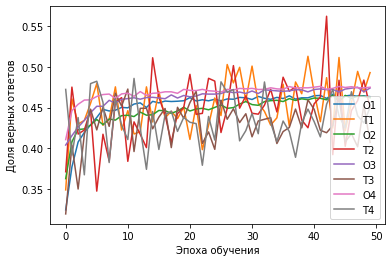

In [ ]:
plt.plot(history1.history['accuracy'],label='O1')
plt.plot(history1.history['val_accuracy'],label='T1')
plt.plot(history2.history['accuracy'],label='O2')
plt.plot(history2.history['val_accuracy'], label='T2')
plt.plot(history3.history['accuracy'], label='O3')
plt.plot(history3.history['val_accuracy'], label='T3')
plt.plot(history4.history['accuracy'], label='O4')
plt.plot(history4.history['val_accuracy'], label='T4')
# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
# Отрисовка легенды
plt.legend()
# Вывод графика
plt.show()


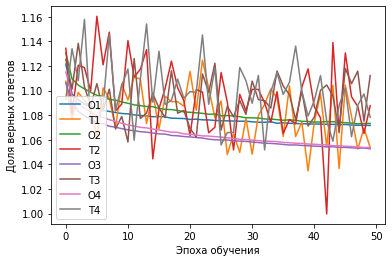

In [ ]:
plt.plot(history1.history['loss'],label='O1')
plt.plot(history1.history['val_loss'],label='T1')
plt.plot(history2.history['loss'],label='O2')
plt.plot(history2.history['val_loss'], label='T2')
plt.plot(history3.history['loss'], label='O3')
plt.plot(history3.history['val_loss'], label='T3')
plt.plot(history4.history['loss'], label='O4')
plt.plot(history4.history['val_loss'], label='T4')
# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
# Отрисовка легенды
plt.legend()
# Вывод графика
plt.show()

In [ ]:
model121 = ModelConvDense1(x_data_train_t2[0].shape,8)
model122 = ModelConvDense1(x_data_train_t2[0].shape,32)
model123 = ModelConvDense2(x_data_train_t2[0].shape,20,8)
model124 = ModelConvDense2(x_data_train_t2[0].shape,20,16)
model121.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model122.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model123.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model124.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model121.fit(x_data_train_t2,y_data_train_tpl,validation_data=(x_data_test_t2,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model121.save(FileDir+"model121.h5")
gc.collect()
history2=model122.fit(x_data_train_t2,y_data_train_tpl,validation_data=(x_data_test_t2,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model122.save(FileDir+"model122.h5")
gc.collect()
history3=model123.fit(x_data_train_t2,y_data_train_tpl,validation_data=(x_data_test_t2,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model123.save(FileDir+"model123.h5")
gc.collect()
history4=model124.fit(x_data_train_t2,y_data_train_tpl,validation_data=(x_data_test_t2,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model124.save(FileDir+"model124.h5")
gc.collect()


Epoch 1/50
81/81 - 5s - loss: 1.1325 - accuracy: 0.3592 - mae: 0.4431 - val_loss: 1.1270 - val_accuracy: 0.3426 - val_mae: 0.4448 - 5s/epoch - 58ms/step
Epoch 2/50
81/81 - 3s - loss: 1.1073 - accuracy: 0.4009 - mae: 0.4376 - val_loss: 1.1144 - val_accuracy: 0.3641 - val_mae: 0.4424 - 3s/epoch - 42ms/step
Epoch 3/50
81/81 - 3s - loss: 1.0977 - accuracy: 0.4276 - mae: 0.4351 - val_loss: 1.1135 - val_accuracy: 0.3763 - val_mae: 0.4415 - 3s/epoch - 42ms/step
Epoch 4/50
81/81 - 3s - loss: 1.0926 - accuracy: 0.4373 - mae: 0.4342 - val_loss: 1.1098 - val_accuracy: 0.3917 - val_mae: 0.4398 - 3s/epoch - 41ms/step
Epoch 5/50
81/81 - 3s - loss: 1.0893 - accuracy: 0.4420 - mae: 0.4337 - val_loss: 1.0928 - val_accuracy: 0.4250 - val_mae: 0.4357 - 3s/epoch - 41ms/step
Epoch 6/50
81/81 - 3s - loss: 1.0870 - accuracy: 0.4559 - mae: 0.4318 - val_loss: 1.0980 - val_accuracy: 0.4201 - val_mae: 0.4365 - 3s/epoch - 42ms/step
Epoch 7/50
81/81 - 3s - loss: 1.0854 - accuracy: 0.4563 - mae: 0.4318 - val_loss: 

1629

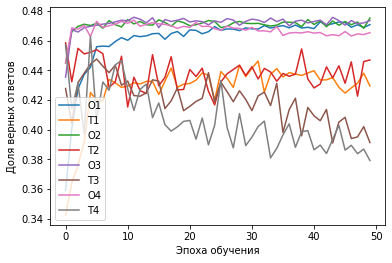

In [ ]:
plt.plot(history1.history['accuracy'],label='O1')
plt.plot(history1.history['val_accuracy'],label='T1')
plt.plot(history2.history['accuracy'],label='O2')
plt.plot(history2.history['val_accuracy'], label='T2')
plt.plot(history3.history['accuracy'], label='O3')
plt.plot(history3.history['val_accuracy'], label='T3')
plt.plot(history4.history['accuracy'], label='O4')
plt.plot(history4.history['val_accuracy'], label='T4')
# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
# Отрисовка легенды
plt.legend()
# Вывод графика
plt.show()

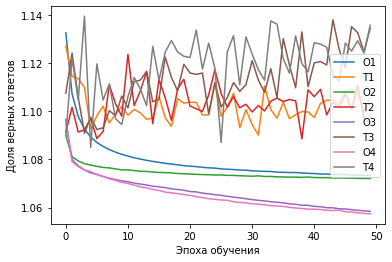

In [ ]:
plt.plot(history1.history['loss'],label='O1')
plt.plot(history1.history['val_loss'],label='T1')
plt.plot(history2.history['loss'],label='O2')
plt.plot(history2.history['val_loss'], label='T2')
plt.plot(history3.history['loss'], label='O3')
plt.plot(history3.history['val_loss'], label='T3')
plt.plot(history4.history['loss'], label='O4')
plt.plot(history4.history['val_loss'], label='T4')
# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
# Отрисовка легенды
plt.legend()
# Вывод графика
plt.show()

In [ ]:
del model121
del model122
del model123
del model124
del history1
del history2
del history3
del history4


In [ ]:
model131 = ModelConvDense1(x_data_train_t3[0].shape,8)
model132 = ModelConvDense1(x_data_train_t3[0].shape,32)
model133 = ModelConvDense2(x_data_train_t3[0].shape,20,8)
model134 = ModelConvDense2(x_data_train_t3[0].shape,20,16)
model131.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model132.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model133.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model134.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model131.fit(x_data_train_t3,y_data_train_tpl,validation_data=(x_data_test_t3,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model131.save(FileDir+"model131.h5")
del model131
history2=model132.fit(x_data_train_t3,y_data_train_tpl,validation_data=(x_data_test_t3,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model132.save(FileDir+"model132.h5")
del model132
history3=model133.fit(x_data_train_t3,y_data_train_tpl,validation_data=(x_data_test_t3,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model133.save(FileDir+"model133.h5")
del model133
history4=model134.fit(x_data_train_t3,y_data_train_tpl,validation_data=(x_data_test_t3,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model134.save(FileDir+"model134.h5")
del model134

Epoch 1/50
81/81 - 4s - loss: 1.0998 - accuracy: 0.4051 - mae: 0.4351 - val_loss: 1.0637 - val_accuracy: 0.4480 - val_mae: 0.4307 - 4s/epoch - 55ms/step
Epoch 2/50
81/81 - 3s - loss: 1.0735 - accuracy: 0.4850 - mae: 0.4247 - val_loss: 1.0521 - val_accuracy: 0.4618 - val_mae: 0.4257 - 3s/epoch - 43ms/step
Epoch 3/50
81/81 - 3s - loss: 1.0684 - accuracy: 0.5021 - mae: 0.4210 - val_loss: 1.0651 - val_accuracy: 0.4503 - val_mae: 0.4272 - 3s/epoch - 43ms/step
Epoch 4/50
81/81 - 3s - loss: 1.0656 - accuracy: 0.5014 - mae: 0.4204 - val_loss: 1.0641 - val_accuracy: 0.4560 - val_mae: 0.4260 - 3s/epoch - 43ms/step
Epoch 5/50
81/81 - 3s - loss: 1.0634 - accuracy: 0.5045 - mae: 0.4196 - val_loss: 1.0728 - val_accuracy: 0.4494 - val_mae: 0.4274 - 3s/epoch - 42ms/step
Epoch 6/50
81/81 - 3s - loss: 1.0617 - accuracy: 0.5077 - mae: 0.4189 - val_loss: 1.0680 - val_accuracy: 0.4557 - val_mae: 0.4257 - 3s/epoch - 43ms/step
Epoch 7/50
81/81 - 3s - loss: 1.0606 - accuracy: 0.5083 - mae: 0.4181 - val_loss: 

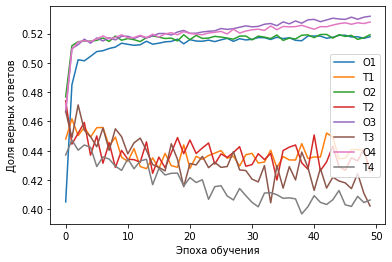

In [ ]:
plt.plot(history1.history['accuracy'],          label='O1')
plt.plot(history1.history['val_accuracy'],          label='T1')
plt.plot(history2.history['accuracy'],          label='O2')
plt.plot(history2.history['val_accuracy'],          label='T2')
plt.plot(history3.history['accuracy'],          label='O3')
plt.plot(history3.history['val_accuracy'],          label='T3')
plt.plot(history4.history['accuracy'],          label='O4')
plt.plot(history4.history['val_accuracy'],          label='T4')
# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
# Отрисовка легенды
plt.legend()
# Вывод графика
plt.show()

In [ ]:
del history1
del history2
del history3
del history4

In [ ]:
model141 = ModelConvDense1(x_data_train_t4[0].shape,8)
model142 = ModelConvDense1(x_data_train_t4[0].shape,32)
model143 = ModelConvDense2(x_data_train_t4[0].shape,20,8)
model144 = ModelConvDense2(x_data_train_t4[0].shape,20,16)
model141.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model142.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model143.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model144.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model141.fit(x_data_train_t4,y_data_train_tpl,validation_data=(x_data_test_t4,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model141.save(FileDir+"model141.h5")
del model141
history2=model142.fit(x_data_train_t4,y_data_train_tpl,validation_data=(x_data_test_t4,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model142.save(FileDir+"model142.h5")
del model142
history3=model143.fit(x_data_train_t4,y_data_train_tpl,validation_data=(x_data_test_t4,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model143.save(FileDir+"model143.h5")
del model143
history4=model144.fit(x_data_train_t4,y_data_train_tpl,validation_data=(x_data_test_t4,y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model144.save(FileDir+"model144.h5")
del model144

Epoch 1/50
81/81 - 4s - loss: 1.0831 - accuracy: 0.4789 - mae: 0.4259 - val_loss: 1.0206 - val_accuracy: 0.5325 - val_mae: 0.4179 - 4s/epoch - 52ms/step
Epoch 2/50
81/81 - 3s - loss: 1.0514 - accuracy: 0.5426 - mae: 0.4096 - val_loss: 1.0309 - val_accuracy: 0.5129 - val_mae: 0.4169 - 3s/epoch - 41ms/step
Epoch 3/50
81/81 - 3s - loss: 1.0435 - accuracy: 0.5503 - mae: 0.4051 - val_loss: 1.0305 - val_accuracy: 0.5136 - val_mae: 0.4138 - 3s/epoch - 42ms/step
Epoch 4/50
81/81 - 3s - loss: 1.0392 - accuracy: 0.5535 - mae: 0.4024 - val_loss: 1.0215 - val_accuracy: 0.5231 - val_mae: 0.4097 - 3s/epoch - 42ms/step
Epoch 5/50
81/81 - 3s - loss: 1.0369 - accuracy: 0.5557 - mae: 0.4007 - val_loss: 1.0357 - val_accuracy: 0.5116 - val_mae: 0.4119 - 3s/epoch - 41ms/step
Epoch 6/50
81/81 - 3s - loss: 1.0352 - accuracy: 0.5571 - mae: 0.3994 - val_loss: 1.0448 - val_accuracy: 0.5065 - val_mae: 0.4130 - 3s/epoch - 42ms/step
Epoch 7/50
81/81 - 3s - loss: 1.0342 - accuracy: 0.5565 - mae: 0.3990 - val_loss: 

In [ ]:
plt.plot(history1.history['accuracy'],label='O1')
plt.plot(history1.history['val_accuracy'],label='T1')
plt.plot(history2.history['accuracy'],label='O2')
plt.plot(history2.history['val_accuracy'],label='T2')
plt.plot(history3.history['accuracy'],label='O3')
plt.plot(history3.history['val_accuracy'],label='T3')
plt.plot(history4.history['accuracy'],label='O4')
plt.plot(history4.history['val_accuracy'],label='T4')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
del history1
del history2
del history3
del history4

In [ ]:
model21 = Model3ConvDense1(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,20,8,OutActivation='softmax')
model22 = Model3ConvDense1(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,20,32,OutActivation='softmax')
model21.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model22.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model21.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model21.save(FileDir+"model21.h5")
del model21
history2=model22.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model22.save(FileDir+"model22.h5")
del model22

Epoch 1/50
81/81 - 21s - loss: 1.1144 - accuracy: 0.3846 - mae: 0.4380 - val_loss: 1.0811 - val_accuracy: 0.4270 - val_mae: 0.4326 - 21s/epoch - 262ms/step
Epoch 2/50
81/81 - 17s - loss: 1.0738 - accuracy: 0.4392 - mae: 0.4290 - val_loss: 1.0594 - val_accuracy: 0.4439 - val_mae: 0.4256 - 17s/epoch - 212ms/step
Epoch 3/50
81/81 - 17s - loss: 1.0586 - accuracy: 0.4527 - mae: 0.4230 - val_loss: 1.0443 - val_accuracy: 0.4540 - val_mae: 0.4197 - 17s/epoch - 213ms/step
Epoch 4/50
81/81 - 17s - loss: 1.0494 - accuracy: 0.4585 - mae: 0.4191 - val_loss: 1.0270 - val_accuracy: 0.4794 - val_mae: 0.4142 - 17s/epoch - 213ms/step
Epoch 5/50
81/81 - 17s - loss: 1.0434 - accuracy: 0.4631 - mae: 0.4162 - val_loss: 1.0227 - val_accuracy: 0.4712 - val_mae: 0.4119 - 17s/epoch - 212ms/step
Epoch 6/50
81/81 - 17s - loss: 1.0388 - accuracy: 0.4663 - mae: 0.4140 - val_loss: 1.0183 - val_accuracy: 0.4717 - val_mae: 0.4104 - 17s/epoch - 213ms/step
Epoch 7/50
81/81 - 19s - loss: 1.0355 - accuracy: 0.4687 - mae: 

In [ ]:
del history1
del history2

In [ ]:
model23 = Model3ConvDense1(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,50,8,OutActivation='softmax')
model24 = Model3ConvDense1(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,50,32,OutActivation='softmax')
model23.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model24.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history3=model23.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model23.save(FileDir+"model23.h5")
del model23
history4=model24.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model24.save(FileDir+"model24.h5")
del model24
gc.collect()

Epoch 1/50
81/81 - 19s - loss: 1.1278 - accuracy: 0.3725 - mae: 0.4398 - val_loss: 1.0888 - val_accuracy: 0.4153 - val_mae: 0.4345 - 19s/epoch - 234ms/step
Epoch 2/50
81/81 - 17s - loss: 1.0809 - accuracy: 0.4311 - mae: 0.4309 - val_loss: 1.0604 - val_accuracy: 0.4492 - val_mae: 0.4262 - 17s/epoch - 211ms/step
Epoch 3/50
81/81 - 17s - loss: 1.0641 - accuracy: 0.4491 - mae: 0.4247 - val_loss: 1.0510 - val_accuracy: 0.4444 - val_mae: 0.4223 - 17s/epoch - 211ms/step
Epoch 4/50
81/81 - 21s - loss: 1.0534 - accuracy: 0.4568 - mae: 0.4205 - val_loss: 1.0323 - val_accuracy: 0.4661 - val_mae: 0.4158 - 21s/epoch - 259ms/step
Epoch 5/50
81/81 - 17s - loss: 1.0464 - accuracy: 0.4621 - mae: 0.4173 - val_loss: 1.0193 - val_accuracy: 0.4743 - val_mae: 0.4116 - 17s/epoch - 210ms/step
Epoch 6/50
81/81 - 17s - loss: 1.0411 - accuracy: 0.4653 - mae: 0.4148 - val_loss: 1.0270 - val_accuracy: 0.4631 - val_mae: 0.4128 - 17s/epoch - 211ms/step
Epoch 7/50
81/81 - 17s - loss: 1.0371 - accuracy: 0.4676 - mae: 

4072

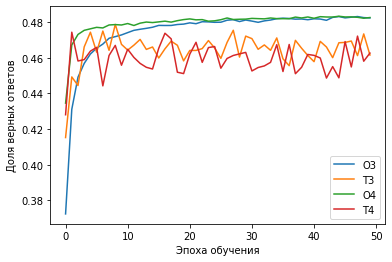

In [ ]:
plt.plot(history3.history['accuracy'],label='O3')
plt.plot(history3.history['val_accuracy'],label='T3')
plt.plot(history4.history['accuracy'],label='O4')
plt.plot(history4.history['val_accuracy'],label='T4')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model31 = Model3ConvDense2(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,20,8,OutActivation='softmax')
model32 = Model3ConvDense2(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,20,32,OutActivation='softmax')
model31.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model32.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model31.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model31.save(FileDir+"model31.h5")
del model31
history2=model32.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model32.save(FileDir+"model32.h5")
del model32
gc.collect()

Epoch 1/50
81/81 - 37s - loss: 1.1514 - accuracy: 0.4224 - mae: 0.4256 - val_loss: 1.0739 - val_accuracy: 0.4724 - val_mae: 0.4062 - 37s/epoch - 456ms/step
Epoch 2/50
81/81 - 34s - loss: 1.0979 - accuracy: 0.4597 - mae: 0.4126 - val_loss: 1.0596 - val_accuracy: 0.4801 - val_mae: 0.4003 - 34s/epoch - 415ms/step
Epoch 3/50
81/81 - 32s - loss: 1.0843 - accuracy: 0.4660 - mae: 0.4105 - val_loss: 1.0698 - val_accuracy: 0.4677 - val_mae: 0.4079 - 32s/epoch - 396ms/step
Epoch 4/50
81/81 - 30s - loss: 1.0753 - accuracy: 0.4709 - mae: 0.4095 - val_loss: 1.0645 - val_accuracy: 0.4678 - val_mae: 0.4071 - 30s/epoch - 373ms/step
Epoch 5/50
81/81 - 30s - loss: 1.0685 - accuracy: 0.4739 - mae: 0.4090 - val_loss: 1.0662 - val_accuracy: 0.4649 - val_mae: 0.4083 - 30s/epoch - 374ms/step
Epoch 6/50
81/81 - 34s - loss: 1.0653 - accuracy: 0.4735 - mae: 0.4088 - val_loss: 1.0681 - val_accuracy: 0.4613 - val_mae: 0.4098 - 34s/epoch - 425ms/step
Epoch 7/50
81/81 - 30s - loss: 1.0613 - accuracy: 0.4751 - mae: 

7098

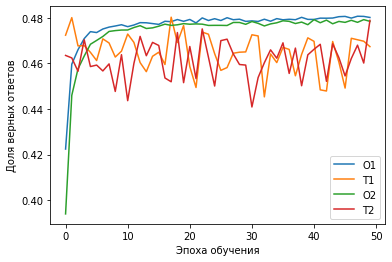

In [ ]:
plt.plot(history1.history['accuracy'],label='O1')
plt.plot(history1.history['val_accuracy'],label='T1')
plt.plot(history2.history['accuracy'],label='O2')
plt.plot(history2.history['val_accuracy'],label='T2')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model33 = Model3ConvDense2(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,50,8,OutActivation='softmax')
model34 = Model3ConvDense2(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,50,32,OutActivation='softmax')
model33.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model34.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history3=model33.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model33.save(FileDir+"model33.h5")
del model33
history4=model34.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model34.save(FileDir+"model34.h5")
del model34
gc.collect()

Epoch 1/50
81/81 - 34s - loss: 1.2693 - accuracy: 0.4034 - mae: 0.4294 - val_loss: 1.1822 - val_accuracy: 0.4765 - val_mae: 0.4121 - 34s/epoch - 422ms/step
Epoch 2/50
81/81 - 31s - loss: 1.2052 - accuracy: 0.4514 - mae: 0.4151 - val_loss: 1.1655 - val_accuracy: 0.4751 - val_mae: 0.4088 - 31s/epoch - 380ms/step
Epoch 3/50
81/81 - 31s - loss: 1.1834 - accuracy: 0.4612 - mae: 0.4112 - val_loss: 1.1634 - val_accuracy: 0.4601 - val_mae: 0.4090 - 31s/epoch - 381ms/step
Epoch 4/50
81/81 - 31s - loss: 1.1677 - accuracy: 0.4671 - mae: 0.4092 - val_loss: 1.1511 - val_accuracy: 0.4621 - val_mae: 0.4080 - 31s/epoch - 383ms/step
Epoch 5/50
81/81 - 35s - loss: 1.1558 - accuracy: 0.4709 - mae: 0.4086 - val_loss: 1.1405 - val_accuracy: 0.4645 - val_mae: 0.4064 - 35s/epoch - 433ms/step
Epoch 6/50
81/81 - 31s - loss: 1.1457 - accuracy: 0.4717 - mae: 0.4081 - val_loss: 1.1340 - val_accuracy: 0.4690 - val_mae: 0.4062 - 31s/epoch - 380ms/step
Epoch 7/50
81/81 - 33s - loss: 1.1371 - accuracy: 0.4729 - mae: 

2001

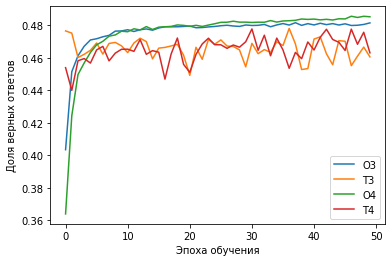

In [ ]:
plt.plot(history3.history['accuracy'],label='O3')
plt.plot(history3.history['val_accuracy'],label='T3')
plt.plot(history4.history['accuracy'],label='O4')
plt.plot(history4.history['val_accuracy'],label='T4')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model41 = create_Conv_short4In(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,None,20,8,l2Conv=0.005,NumOut=NClasses,UseTimeAdd=False)
model41.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model41.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=25,batch_size=4096,verbose=2)
model41.save(FileDir+"model41.h5")
del model41
gc.collect()

Epoch 1/25
81/81 - 34s - loss: 2.3729 - accuracy: 0.3938 - mae: 0.4264 - val_loss: 1.9613 - val_accuracy: 0.2735 - val_mae: 0.4454 - 34s/epoch - 415ms/step
Epoch 2/25
81/81 - 25s - loss: 1.7516 - accuracy: 0.4380 - mae: 0.4176 - val_loss: 1.6569 - val_accuracy: 0.2970 - val_mae: 0.4445 - 25s/epoch - 303ms/step
Epoch 3/25
81/81 - 24s - loss: 1.5126 - accuracy: 0.4556 - mae: 0.4124 - val_loss: 1.4949 - val_accuracy: 0.3569 - val_mae: 0.4429 - 24s/epoch - 301ms/step
Epoch 4/25
81/81 - 24s - loss: 1.3774 - accuracy: 0.4687 - mae: 0.4078 - val_loss: 1.3997 - val_accuracy: 0.3500 - val_mae: 0.4419 - 24s/epoch - 301ms/step
Epoch 5/25
81/81 - 24s - loss: 1.2906 - accuracy: 0.4798 - mae: 0.4044 - val_loss: 1.3236 - val_accuracy: 0.4083 - val_mae: 0.4378 - 24s/epoch - 300ms/step
Epoch 6/25
81/81 - 26s - loss: 1.2314 - accuracy: 0.4868 - mae: 0.4013 - val_loss: 1.2683 - val_accuracy: 0.4160 - val_mae: 0.4332 - 26s/epoch - 324ms/step
Epoch 7/25
81/81 - 28s - loss: 1.1872 - accuracy: 0.4940 - mae: 

5303

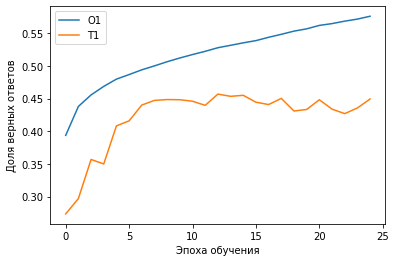

In [ ]:
plt.plot(history1.history['accuracy'],label='O1')
plt.plot(history1.history['val_accuracy'],label='T1')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model42 = create_Conv_short4In(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,None,20,32,l2Conv=0.005,NumOut=NClasses,UseTimeAdd=False)
model42.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history2=model42.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=25,batch_size=4096,verbose=2)
model42.save(FileDir+"model42.h5")
del model42
gc.collect()

Epoch 1/25
81/81 - 135s - loss: 4.2252 - accuracy: 0.4371 - mae: 0.4080 - val_loss: 2.4839 - val_accuracy: 0.4011 - val_mae: 0.4438 - 135s/epoch - 2s/step
Epoch 2/25
81/81 - 131s - loss: 1.9539 - accuracy: 0.4894 - mae: 0.3943 - val_loss: 1.7318 - val_accuracy: 0.3971 - val_mae: 0.4440 - 131s/epoch - 2s/step
Epoch 3/25
81/81 - 131s - loss: 1.4720 - accuracy: 0.5216 - mae: 0.3836 - val_loss: 1.4859 - val_accuracy: 0.3975 - val_mae: 0.4431 - 131s/epoch - 2s/step
Epoch 4/25
81/81 - 131s - loss: 1.2748 - accuracy: 0.5510 - mae: 0.3723 - val_loss: 1.3764 - val_accuracy: 0.3978 - val_mae: 0.4413 - 131s/epoch - 2s/step
Epoch 5/25
81/81 - 131s - loss: 1.1654 - accuracy: 0.5802 - mae: 0.3601 - val_loss: 1.3165 - val_accuracy: 0.4136 - val_mae: 0.4378 - 131s/epoch - 2s/step
Epoch 6/25
81/81 - 128s - loss: 1.0869 - accuracy: 0.6101 - mae: 0.3461 - val_loss: 1.2795 - val_accuracy: 0.4195 - val_mae: 0.4311 - 128s/epoch - 2s/step
Epoch 7/25
81/81 - 131s - loss: 1.0282 - accuracy: 0.6364 - mae: 0.330

4058

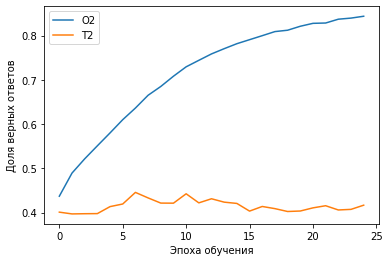

In [ ]:
plt.plot(history2.history['accuracy'],label='O2')
plt.plot(history2.history['val_accuracy'],label='T2')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
del history2

In [ ]:
model43 = create_Conv_short4In(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,None,50,8,l2Conv=0.005,NumOut=NClasses,UseTimeAdd=False)
model43.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history3=model43.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=50,batch_size=4096,verbose=2)
model43.save(FileDir+"model43.h5")
gc.collect()

Epoch 1/50
81/81 - 34s - loss: 2.3782 - accuracy: 0.4093 - mae: 0.4192 - val_loss: 1.9483 - val_accuracy: 0.4576 - val_mae: 0.4412 - 34s/epoch - 425ms/step
Epoch 2/50
81/81 - 30s - loss: 1.7391 - accuracy: 0.4528 - mae: 0.4087 - val_loss: 1.6354 - val_accuracy: 0.4587 - val_mae: 0.4390 - 30s/epoch - 367ms/step
Epoch 3/50
81/81 - 25s - loss: 1.4973 - accuracy: 0.4691 - mae: 0.4046 - val_loss: 1.4711 - val_accuracy: 0.4543 - val_mae: 0.4363 - 25s/epoch - 312ms/step
Epoch 4/50
81/81 - 26s - loss: 1.3621 - accuracy: 0.4799 - mae: 0.4014 - val_loss: 1.3680 - val_accuracy: 0.4629 - val_mae: 0.4331 - 26s/epoch - 315ms/step
Epoch 5/50
81/81 - 25s - loss: 1.2756 - accuracy: 0.4892 - mae: 0.3987 - val_loss: 1.2921 - val_accuracy: 0.4743 - val_mae: 0.4279 - 25s/epoch - 315ms/step
Epoch 6/50
81/81 - 25s - loss: 1.2160 - accuracy: 0.4970 - mae: 0.3960 - val_loss: 1.2347 - val_accuracy: 0.4870 - val_mae: 0.4225 - 25s/epoch - 314ms/step
Epoch 7/50
81/81 - 25s - loss: 1.1720 - accuracy: 0.5032 - mae: 

15837

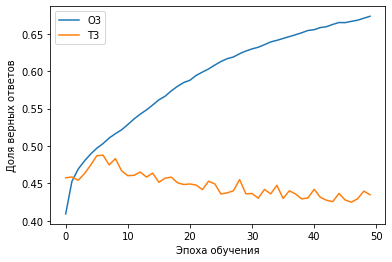

In [ ]:
plt.plot(history3.history['accuracy'],label='O3')
plt.plot(history3.history['val_accuracy'],label='T3')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


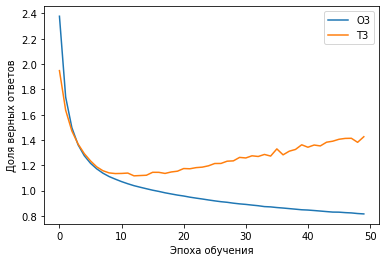

In [ ]:
plt.plot(history3.history['loss'],label='O3')
plt.plot(history3.history['val_loss'],label='T3')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [ ]:
model44 = create_Conv_short4In(x_data_train_t1[0].shape,x_data_train_t2[0].shape,x_data_train_t3[0].shape,x_data_train_t4[0].shape,None,50,32,l2Conv=0.005,NumOut=NClasses,UseTimeAdd=False)
model44.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history4=model44.fit([x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=35,batch_size=4096,verbose=2)
model44.save(FileDir+"model44.h5")
gc.collect()

Epoch 1/35
81/81 - 140s - loss: 4.8616 - accuracy: 0.4314 - mae: 0.4033 - val_loss: 3.0462 - val_accuracy: 0.3227 - val_mae: 0.4447 - 140s/epoch - 2s/step
Epoch 2/35
81/81 - 131s - loss: 2.4245 - accuracy: 0.4892 - mae: 0.3876 - val_loss: 2.1139 - val_accuracy: 0.2730 - val_mae: 0.4459 - 131s/epoch - 2s/step
Epoch 3/35
81/81 - 135s - loss: 1.7775 - accuracy: 0.5263 - mae: 0.3754 - val_loss: 1.7569 - val_accuracy: 0.2730 - val_mae: 0.4454 - 135s/epoch - 2s/step
Epoch 4/35
81/81 - 133s - loss: 1.4797 - accuracy: 0.5626 - mae: 0.3611 - val_loss: 1.5781 - val_accuracy: 0.3688 - val_mae: 0.4433 - 133s/epoch - 2s/step
Epoch 5/35
81/81 - 133s - loss: 1.3129 - accuracy: 0.5942 - mae: 0.3465 - val_loss: 1.4854 - val_accuracy: 0.3700 - val_mae: 0.4420 - 133s/epoch - 2s/step
Epoch 6/35
81/81 - 130s - loss: 1.1945 - accuracy: 0.6289 - mae: 0.3300 - val_loss: 1.4171 - val_accuracy: 0.4011 - val_mae: 0.4367 - 130s/epoch - 2s/step
Epoch 7/35
81/81 - 135s - loss: 1.1078 - accuracy: 0.6569 - mae: 0.312

13474

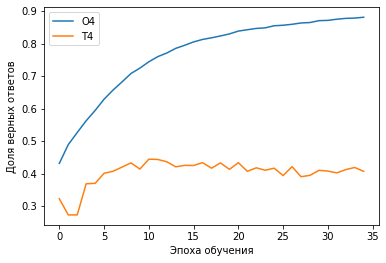

In [ ]:
plt.plot(history4.history['accuracy'],label='O4')
plt.plot(history4.history['val_accuracy'],label='T4')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

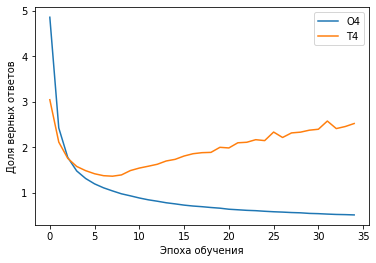

In [ ]:
plt.plot(history4.history['loss'],label='O4')
plt.plot(history4.history['val_loss'],label='T4')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model51 = Model3ConvDense2_2In(x_data_train_t3[0].shape,x_data_train_t4[0].shape,20,8,OutActivation='softmax')
model51.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model51.fit([x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=35,batch_size=4096,verbose=2)
model51.save(FileDir+"model51.h5")
model52 = Model3ConvDense2_2In(x_data_train_t3[0].shape,x_data_train_t4[0].shape,20,32,OutActivation='softmax')
model52.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history2=model52.fit([x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=35,batch_size=4096,verbose=2)
model52.save(FileDir+"model52.h5")
model53 = Model3ConvDense2_2In(x_data_train_t3[0].shape,x_data_train_t4[0].shape,50,8,OutActivation='softmax')
model53.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history3=model53.fit([x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=35,batch_size=4096,verbose=2)
model53.save(FileDir+"model53.h5")
model54 = Model3ConvDense2_2In(x_data_train_t3[0].shape,x_data_train_t4[0].shape,50,32,OutActivation='softmax')
model54.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history4=model54.fit([x_data_train_t3,x_data_train_t4],y_data_train_tpl,validation_data=([x_data_test_t3,x_data_test_t4],y_data_test_tpl),class_weight=WeightMatrix2,epochs=35,batch_size=4096,verbose=2)
model54.save(FileDir+"model54.h5")



Epoch 1/35
81/81 - 19s - loss: 1.1280 - accuracy: 0.4311 - mae: 0.4224 - val_loss: 1.0864 - val_accuracy: 0.4670 - val_mae: 0.4112 - 19s/epoch - 229ms/step
Epoch 2/35
81/81 - 14s - loss: 1.0857 - accuracy: 0.4632 - mae: 0.4127 - val_loss: 1.0863 - val_accuracy: 0.4555 - val_mae: 0.4114 - 14s/epoch - 170ms/step
Epoch 3/35
81/81 - 14s - loss: 1.0746 - accuracy: 0.4671 - mae: 0.4109 - val_loss: 1.0749 - val_accuracy: 0.4660 - val_mae: 0.4105 - 14s/epoch - 170ms/step
Epoch 4/35
81/81 - 14s - loss: 1.0680 - accuracy: 0.4700 - mae: 0.4102 - val_loss: 1.0775 - val_accuracy: 0.4604 - val_mae: 0.4121 - 14s/epoch - 170ms/step
Epoch 5/35
81/81 - 14s - loss: 1.0631 - accuracy: 0.4707 - mae: 0.4100 - val_loss: 1.0687 - val_accuracy: 0.4602 - val_mae: 0.4103 - 14s/epoch - 170ms/step
Epoch 6/35
81/81 - 14s - loss: 1.0591 - accuracy: 0.4715 - mae: 0.4095 - val_loss: 1.0587 - val_accuracy: 0.4644 - val_mae: 0.4085 - 14s/epoch - 170ms/step
Epoch 7/35
81/81 - 14s - loss: 1.0560 - accuracy: 0.4731 - mae: 

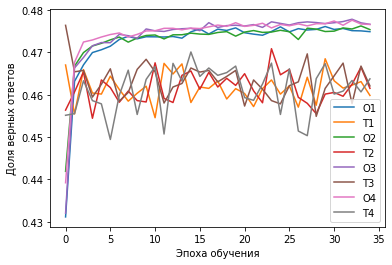

In [ ]:
plt.plot(history1.history['accuracy'],label='O1')
plt.plot(history1.history['val_accuracy'],label='T1')
plt.plot(history2.history['accuracy'],label='O2')
plt.plot(history2.history['val_accuracy'],label='T2')
plt.plot(history3.history['accuracy'],label='O3')
plt.plot(history3.history['val_accuracy'],label='T3')
plt.plot(history4.history['accuracy'],label='O4')
plt.plot(history4.history['val_accuracy'],label='T4')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

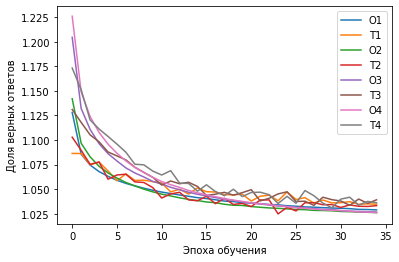

In [ ]:
plt.plot(history1.history['loss'],label='O1')
plt.plot(history1.history['val_loss'],label='T1')
plt.plot(history2.history['loss'],label='O2')
plt.plot(history2.history['val_loss'],label='T2')
plt.plot(history3.history['loss'],label='O3')
plt.plot(history3.history['val_loss'],label='T3')
plt.plot(history4.history['loss'],label='O4')
plt.plot(history4.history['val_loss'],label='T4')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Реккурентные

In [ ]:
model215 = ModelLSTM(x_data_train_t1[0].shape,20,32)
model215.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model215.fit(x_data_train_t1,y_data_train_tpl,validation_data=(x_data_test_t1,y_data_test_tpl),class_weight=WeightMatrix2,epochs=30,batch_size=4096,verbose=2)
gc.collect()
model215.save(FileDir+"model215_L5_80.h5")

Epoch 1/30
68/68 - 49s - loss: 1.1000 - accuracy: 0.2458 - mae: 0.4427 - val_loss: 1.0871 - val_accuracy: 0.3073 - val_mae: 0.4379 - 49s/epoch - 726ms/step
Epoch 2/30
68/68 - 30s - loss: 1.0900 - accuracy: 0.3104 - mae: 0.4390 - val_loss: 1.0832 - val_accuracy: 0.3830 - val_mae: 0.4358 - 30s/epoch - 442ms/step
Epoch 3/30
68/68 - 31s - loss: 1.0859 - accuracy: 0.3538 - mae: 0.4373 - val_loss: 1.0894 - val_accuracy: 0.3754 - val_mae: 0.4368 - 31s/epoch - 461ms/step
Epoch 4/30
68/68 - 30s - loss: 1.0824 - accuracy: 0.3753 - mae: 0.4355 - val_loss: 1.0943 - val_accuracy: 0.3686 - val_mae: 0.4372 - 30s/epoch - 437ms/step
Epoch 5/30
68/68 - 30s - loss: 1.0793 - accuracy: 0.3818 - mae: 0.4344 - val_loss: 1.1236 - val_accuracy: 0.3202 - val_mae: 0.4429 - 30s/epoch - 439ms/step
Epoch 6/30
68/68 - 31s - loss: 1.0767 - accuracy: 0.3945 - mae: 0.4332 - val_loss: 1.1053 - val_accuracy: 0.3664 - val_mae: 0.4386 - 31s/epoch - 457ms/step
Epoch 7/30
68/68 - 31s - loss: 1.0746 - accuracy: 0.4016 - mae: 

In [ ]:
model216 = ModelLSTM(x_data_train_t1[0].shape,20,16)
model217 = ModelLSTM(x_data_train_t1[0].shape,20,10)
model216.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model217.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model216.fit(x_data_train_t1,y_data_train_tpl,validation_data=(x_data_test_t1,y_data_test_tpl),class_weight=WeightMatrix2,epochs=30,batch_size=4096,verbose=2)
history1=model217.fit(x_data_train_t1,y_data_train_tpl,validation_data=(x_data_test_t1,y_data_test_tpl),class_weight=WeightMatrix2,epochs=30,batch_size=4096,verbose=2)
gc.collect()
model216.save(FileDir+"model216_L5_80.h5")
model217.save(FileDir+"model217_L5_80.h5")

Epoch 1/30
68/68 - 30s - loss: 1.1044 - accuracy: 0.2223 - mae: 0.4433 - val_loss: 1.0878 - val_accuracy: 0.2340 - val_mae: 0.4396 - 30s/epoch - 435ms/step
Epoch 2/30
68/68 - 19s - loss: 1.0920 - accuracy: 0.2411 - mae: 0.4411 - val_loss: 1.1146 - val_accuracy: 0.2453 - val_mae: 0.4449 - 19s/epoch - 284ms/step
Epoch 3/30
68/68 - 18s - loss: 1.0883 - accuracy: 0.3143 - mae: 0.4395 - val_loss: 1.0969 - val_accuracy: 0.3108 - val_mae: 0.4403 - 18s/epoch - 259ms/step
Epoch 4/30
68/68 - 17s - loss: 1.0858 - accuracy: 0.3399 - mae: 0.4383 - val_loss: 1.0811 - val_accuracy: 0.3673 - val_mae: 0.4362 - 17s/epoch - 254ms/step
Epoch 5/30
68/68 - 17s - loss: 1.0841 - accuracy: 0.3608 - mae: 0.4370 - val_loss: 1.0664 - val_accuracy: 0.4120 - val_mae: 0.4323 - 17s/epoch - 254ms/step
Epoch 6/30
68/68 - 17s - loss: 1.0827 - accuracy: 0.3687 - mae: 0.4361 - val_loss: 1.0820 - val_accuracy: 0.3874 - val_mae: 0.4357 - 17s/epoch - 256ms/step
Epoch 7/30
68/68 - 22s - loss: 1.0815 - accuracy: 0.3798 - mae: 

In [ ]:
model226 = ModelLSTM(x_data_train_t2[0].shape,20,16)
model236 = ModelLSTM(x_data_train_t3[0].shape,20,16)
model246 = ModelLSTM(x_data_train_t4[0].shape,20,16)
model226.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model236.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model246.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model226.fit(x_data_train_t2,y_data_train_tpl,validation_data=(x_data_test_t2,y_data_test_tpl),class_weight=WeightMatrix2,epochs=30,batch_size=4096,verbose=2)
history1=model236.fit(x_data_train_t3,y_data_train_tpl,validation_data=(x_data_test_t3,y_data_test_tpl),class_weight=WeightMatrix2,epochs=30,batch_size=4096,verbose=2)
history1=model246.fit(x_data_train_t4,y_data_train_tpl,validation_data=(x_data_test_t4,y_data_test_tpl),class_weight=WeightMatrix2,epochs=30,batch_size=4096,verbose=2)
gc.collect()
model226.save(FileDir+"model226_L5_80.h5")
model236.save(FileDir+"model236_L5_80.h5")
model246.save(FileDir+"model246_L5_80.h5")

Epoch 1/30
68/68 - 22s - loss: 1.1051 - accuracy: 0.2294 - mae: 0.4455 - val_loss: 1.1089 - val_accuracy: 0.3589 - val_mae: 0.4436 - 22s/epoch - 317ms/step
Epoch 2/30
68/68 - 22s - loss: 1.0958 - accuracy: 0.3970 - mae: 0.4405 - val_loss: 1.1043 - val_accuracy: 0.4348 - val_mae: 0.4407 - 22s/epoch - 328ms/step
Epoch 3/30
68/68 - 28s - loss: 1.0913 - accuracy: 0.4681 - mae: 0.4374 - val_loss: 1.0815 - val_accuracy: 0.4812 - val_mae: 0.4338 - 28s/epoch - 412ms/step
Epoch 4/30
68/68 - 24s - loss: 1.0874 - accuracy: 0.5062 - mae: 0.4340 - val_loss: 1.0807 - val_accuracy: 0.4872 - val_mae: 0.4315 - 24s/epoch - 349ms/step
Epoch 5/30
68/68 - 25s - loss: 1.0842 - accuracy: 0.5217 - mae: 0.4308 - val_loss: 1.0916 - val_accuracy: 0.4849 - val_mae: 0.4323 - 25s/epoch - 374ms/step
Epoch 6/30
68/68 - 29s - loss: 1.0825 - accuracy: 0.5280 - mae: 0.4292 - val_loss: 1.1189 - val_accuracy: 0.4511 - val_mae: 0.4379 - 29s/epoch - 419ms/step
Epoch 7/30
68/68 - 28s - loss: 1.0814 - accuracy: 0.5218 - mae: 

In [ ]:
model228 = ModelLSTM(x_data_train_t2[0].shape,20,8)
model238 = ModelLSTM(x_data_train_t3[0].shape,20,8)
model228.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
model238.compile(loss=my_loss_fn2,optimizer=adamopt,metrics=['accuracy','mae'])
history1=model228.fit(x_data_train_t2,y_data_train_tpl,validation_data=(x_data_test_t2,y_data_test_tpl),class_weight=WeightMatrix2,epochs=30,batch_size=4096,verbose=2)
history1=model238.fit(x_data_train_t3,y_data_train_tpl,validation_data=(x_data_test_t3,y_data_test_tpl),class_weight=WeightMatrix2,epochs=30,batch_size=4096,verbose=2)
gc.collect()
model228.save(FileDir+"model228_L5_80.h5")
model238.save(FileDir+"model238_L5_80.h5")

Epoch 1/30
68/68 - 37s - loss: 1.1033 - accuracy: 0.3075 - mae: 0.4445 - val_loss: 1.1004 - val_accuracy: 0.3161 - val_mae: 0.4425 - 37s/epoch - 542ms/step
Epoch 2/30
68/68 - 7s - loss: 1.0936 - accuracy: 0.3622 - mae: 0.4403 - val_loss: 1.0878 - val_accuracy: 0.4374 - val_mae: 0.4380 - 7s/epoch - 110ms/step
Epoch 3/30
68/68 - 7s - loss: 1.0900 - accuracy: 0.4496 - mae: 0.4373 - val_loss: 1.0862 - val_accuracy: 0.4584 - val_mae: 0.4361 - 7s/epoch - 105ms/step
Epoch 4/30
68/68 - 7s - loss: 1.0875 - accuracy: 0.4788 - mae: 0.4354 - val_loss: 1.1039 - val_accuracy: 0.4476 - val_mae: 0.4384 - 7s/epoch - 105ms/step
Epoch 5/30
68/68 - 7s - loss: 1.0856 - accuracy: 0.4987 - mae: 0.4335 - val_loss: 1.0802 - val_accuracy: 0.4828 - val_mae: 0.4320 - 7s/epoch - 107ms/step
Epoch 6/30
68/68 - 7s - loss: 1.0842 - accuracy: 0.5153 - mae: 0.4315 - val_loss: 1.0992 - val_accuracy: 0.4634 - val_mae: 0.4352 - 7s/epoch - 109ms/step
Epoch 7/30
68/68 - 8s - loss: 1.0831 - accuracy: 0.5125 - mae: 0.4309 - va

Тест сверточных

In [ ]:
#0 - model111
#1 - model112
#2 - model113
#3 - model114
#4 - model121
#5 - model122
#6 - model123
#7 - model124
#8 - model131
#9 - model132
#10 - model133
#11 - model134
#12 - model141
#13 - model142
#14 - model143
#15 - model144
#16 - model11
#17 - model12
#18 - model21
#19 - model22
#20 - model23
#21 - model24
#22 - model31
#23 - model32
#24 - model33
#25 - model34
#26 - model41
#27 - model42
#28 - model43
#29 - model44


In [ ]:

import gc
x_data_train_4=[x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4]
x_data_test_4=[x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4]
x_data_train_34=[x_data_train_t3,x_data_train_t4]
x_data_test_34=[x_data_test_t3,x_data_test_t4]

InDataTrain=[x_data_train_t1,x_data_train_t1,x_data_train_t1,x_data_train_t1,x_data_train_t2,x_data_train_t2,x_data_train_t2,x_data_train_t2,x_data_train_t3,x_data_train_t3,x_data_train_t3,x_data_train_t3,x_data_train_t4,x_data_train_t4,x_data_train_t4,x_data_train_t4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_4,x_data_train_34,x_data_train_34,x_data_train_34,x_data_train_34]
InDataTest=[x_data_test_t1,x_data_test_t1,x_data_test_t1,x_data_test_t1,x_data_test_t2,x_data_test_t2,x_data_test_t2,x_data_test_t2,x_data_test_t3,x_data_test_t3,x_data_test_t3,x_data_test_t3,x_data_test_t4,x_data_test_t4,x_data_test_t4,x_data_test_t4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_4,x_data_test_34,x_data_test_34,x_data_test_34,x_data_test_34]
Models=[]#model111,model112,model113,model114,model121,model122,model123,model124,model131,model132,model133,model134,model141,model142,model143,model144,model21,model22,model23,model24,model31,model32,model33,model34,model41,model42,model43,model44]
ModelNames=["model111","model112","model113","model114","model121","model122","model123","model124","model131","model132","model133","model134","model141","model142","model143","model144","model21","model22","model23","model24","model31","model32","model33","model34","model41","model42","model43","model44","model51","model52","model53","model54"]

custom_objects = {"my_loss_fn2": my_loss_fn2}

for ModelName in ModelNames:
  with tf.keras.utils.custom_object_scope(custom_objects):
    Models.append(load_model(FileDir+ModelName+".h5"))
Borders=[0,0.2,0.5,0.7,0.9,1.2,1.4,1.6,1.8,2,2.5,3,4,5]
TestPoints=[]
TrainPoints=[]
TestPointsR=[]
TrainPointsR=[]
TestPointsBuy=[]
TrainPointsBuy=[]
TestPointsSell=[]
TrainPointsSell=[]
stds=[]
means=[]
for i,Model in enumerate(Models):
  TrainSeqModel=[]
  TestSeqModel=[]
  TrainSeqModelR=[]
  TestSeqModelR=[]
  TrainSeqModelBuy=[]
  TestSeqModelBuy=[]
  TrainSeqModelSell=[]
  TestSeqModelSell=[]
  pred1=Model.predict(InDataTrain[i],verbose=0)
  pred2=Model.predict(InDataTest[i],verbose=0)
  std1=pred1.std(axis=0)
  mean1=pred1.mean(axis=0)
  stds.append(std1)
  means.append(mean1)
  for Border in Borders:
    Profit, Volume,VolumeBuy,VolumeSell, Recall, WinVolumeBuy, WinVolumeSell, LossVolumeBuy, LossVolumeSell=TradeResult(pred1,TemplTrPr,Border=std1*Border)
    Profit2, Volume2,VolumeBuy2,VolumeSell2, Recall2, WinVolumeBuy2, WinVolumeSell2, LossVolumeBuy2, LossVolumeSell2=TradeResult(pred2,TemplTestPr,Border=std1*Border)
    if(Volume>0 and Volume2>0):
      print(i,Border,"%Prof=",int(Profit/Volume*100)/100,int(Profit2/Volume2*100)/100,"rec=",int(Recall*1000)/1000,int(Recall2*1000)/1000,"---train---","Profit=",Profit,"Volume V B S=",Volume,VolumeBuy,VolumeSell,"Recall-", int(Recall*1000)/1000,"PFBuy=",WinVolumeBuy/LossVolumeBuy,"PFSell=",WinVolumeSell/LossVolumeSell,"PF=",(WinVolumeBuy+WinVolumeSell)/(LossVolumeBuy+LossVolumeSell),"---test---","Profit=",Profit2,"Volume V B S=",Volume2,VolumeBuy2,VolumeSell2,"Recall-", int(Recall*1000)/1000,"PFBuy=",WinVolumeBuy2/LossVolumeBuy2,"PFSell=",WinVolumeSell2/LossVolumeSell2,"PF=",(WinVolumeBuy2+WinVolumeSell2)/(LossVolumeBuy2+LossVolumeSell2),std1)
      TrainSeqModel.append(Profit/Volume)
      TestSeqModel.append(Profit2/Volume2)
      TrainSeqModelR.append(Recall)
      TestSeqModelR.append(Recall2)
      TrainSeqModelBuy.append((WinVolumeBuy)/(LossVolumeBuy))
      TestSeqModelBuy.append((WinVolumeBuy2)/(LossVolumeBuy2))
      TrainSeqModelSell.append((WinVolumeSell)/(LossVolumeSell))
      TestSeqModelSell.append((WinVolumeSell2)/(LossVolumeSell2))
    else:
      TrainSeqModel.append(TrainSeqModel[-1])
      TestSeqModel.append(TrainSeqModel[-1])
      TrainSeqModelR.append(0)
      TestSeqModelR.append(0)
      TrainSeqModelBuy.append(0)
      TestSeqModelBuy.append(0)
      TrainSeqModelSell.append(0)
      TestSeqModelSell.append(0)

    gc.collect()
  del pred1
  del pred2
  TrainPoints.append(TrainSeqModel)
  TestPoints.append(TestSeqModel)
  TrainPointsR.append(TrainSeqModelR)
  TestPointsR.append(TestSeqModelR)
  TrainPointsBuy.append(TrainSeqModelBuy)
  TestPointsBuy.append(TestSeqModelBuy)
  TrainPointsSell.append(TrainSeqModelSell)
  TestPointsSell.append(TestSeqModelSell)
  del Model
    #print("---test---",i,"Profit=",Profit,"Volume=",Volume,"Recall-", Recall,"PFBuy=",WinVolumeBuy/LossVolumeBuy,"PFSell=",WinVolumeSell/LossVolumeSell,"PF=",(WinVolumeBuy+WinVolumeSell)/(LossVolumeBuy+LossVolumeSell))
with open(FileDir+'MeansSTDS_32models.pkl', 'wb') as f: pickle.dump([means,stds],f)






0 0 %Prof= 0.26 0.26 rec= 0.207 0.235 ---train--- Profit= 17871.98812599992 Volume V B S= 67953.91000200027 37204.64734899983 30749.262652999787 Recall- 0.207 PFBuy= 1.6657816874237759 PFSell= 1.7740559018861801 PF= 1.7137101555427448 ---test--- Profit= 973.5981609999978 Volume V B S= 3670.808312999997 1989.3750629999965 1681.4332499999973 Recall- 0.207 PFBuy= 1.548717829990082 PFSell= 1.9599283306625843 PF= 1.7219297764232935 [0.07695054 0.09246729 0.06400213]
0 0.2 %Prof= 0.27 0.27 rec= 0.177 0.206 ---train--- Profit= 15827.569735000043 Volume V B S= 58214.590893000175 32630.421366000013 25584.1695269998 Recall- 0.177 PFBuy= 1.7002013966414355 PFSell= 1.8086475880757618 PF= 1.746812080801892 ---test--- Profit= 873.5434769999976 Volume V B S= 3215.9918429999957 1782.6520369999982 1433.3398059999977 Recall- 0.177 PFBuy= 1.5469406519315354 PFSell= 2.0412134595688953 PF= 1.745837978483747 [0.07695054 0.09246729 0.06400213]
0 0.5 %Prof= 0.28 0.28 rec= 0.137 0.168 ---train--- Profit= 12902

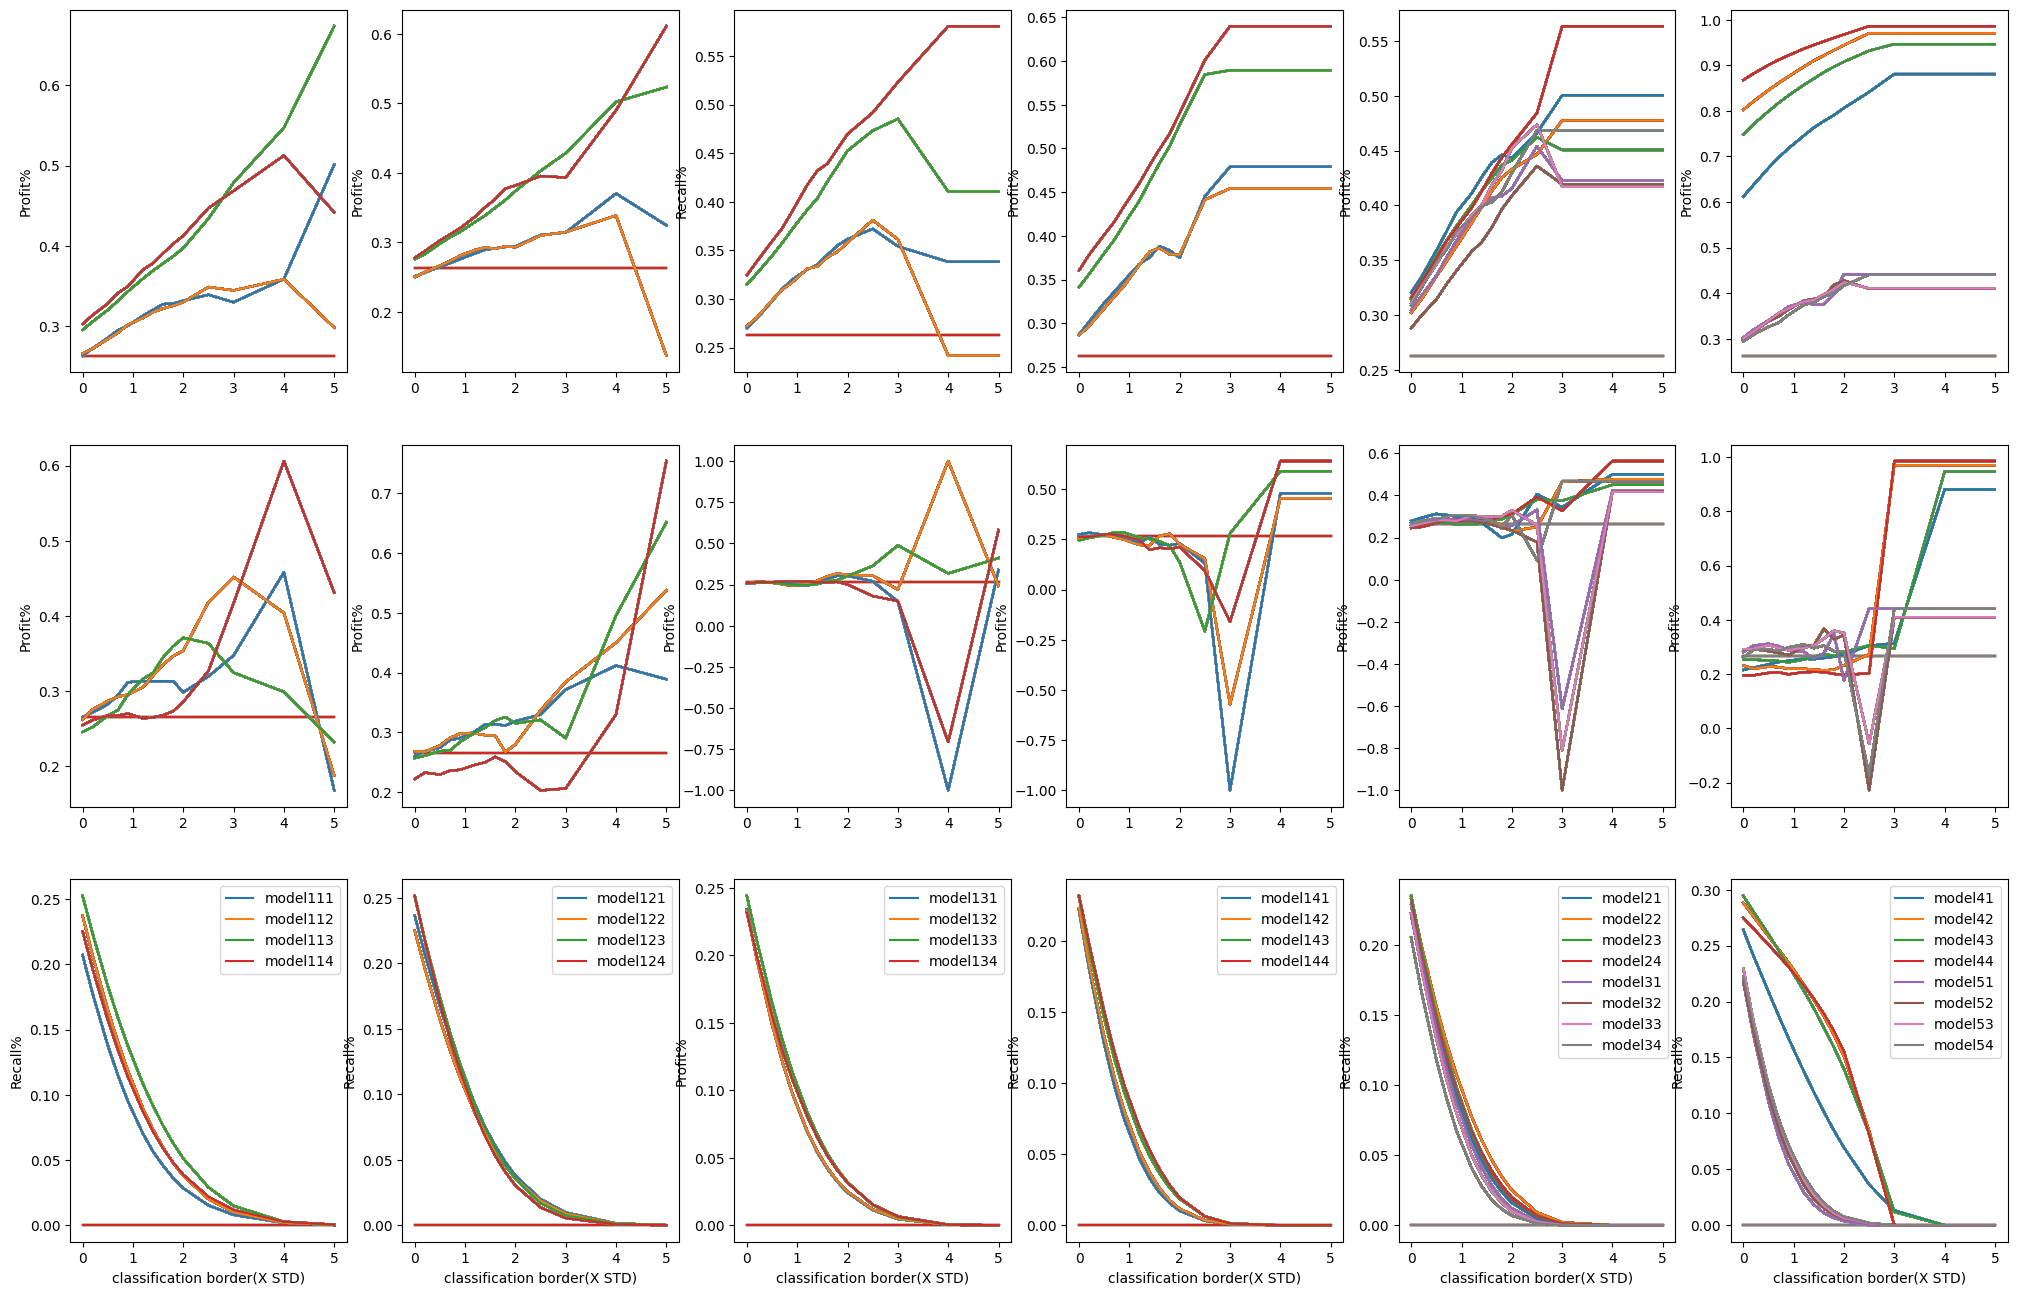

In [ ]:
import matplotlib as mpl
mpl.style.use('default')
#Train normalize
EmptyPlot=np.zeros((len(Borders),30))
for i in range(30):
  EmptyPlot[:,i]=EmptyPlot[:,i]+TrainPoints[0][0]*(1+i*0.00001)
if(True):
    fig, ax= pyplot.subplots(3, 6, figsize=(25, 16))#sharex=True, 
    ax[0,0].plot(Borders,EmptyPlot[:,:14])
    ax[0,0].plot(Borders,np.transpose(TrainPoints[:4]*100))
    ax[0,0].set_ylabel("Profit%")
    ax[0,1].plot(Borders,EmptyPlot[:,:14])
    ax[0,1].plot(Borders,np.transpose(TrainPoints[4:8]*100))
    ax[0,1].set_ylabel("Profit%")
    ax[0,2].plot(Borders,EmptyPlot[:,:14])
    ax[0,2].plot(Borders,np.transpose(TrainPoints[8:12]*100))
    ax[0,2].set_ylabel("Recall%")
    ax[0,3].plot(Borders,EmptyPlot[:,:14])
    ax[0,3].plot(Borders,np.transpose(TrainPoints[12:16]*100))
    ax[0,3].set_ylabel("Profit%")
    ax[0,4].plot(Borders,EmptyPlot[:,:18])
    ax[0,4].plot(Borders,np.transpose(TrainPoints[16:24]*100))
    ax[0,4].set_ylabel("Profit%")
    ax[0,5].plot(Borders,EmptyPlot[:,:18])
    ax[0,5].plot(Borders,np.transpose(TrainPoints[24:]*100))
    ax[0,5].set_ylabel("Profit%")
    EmptyPlot=EmptyPlot*0
    for i in range(30):
      EmptyPlot[:,i]=EmptyPlot[:,i]+TestPoints[0][0]*(1+i*0.00001)
    ax[1,0].plot(Borders,EmptyPlot[:,:14])
    ax[1,0].plot(Borders,np.transpose(TestPoints[:4]*100))
    ax[1,0].set_ylabel("Profit%")
    ax[1,1].plot(Borders,EmptyPlot[:,:14])
    ax[1,1].plot(Borders,np.transpose(TestPoints[4:8]*100))
    ax[1,1].set_ylabel("Profit%")
    ax[1,2].plot(Borders,EmptyPlot[:,:14])
    ax[1,2].plot(Borders,np.transpose(TestPoints[8:12]*100))
    ax[1,2].set_ylabel("Profit%")
    ax[1,3].plot(Borders,EmptyPlot[:,:14])
    ax[1,3].plot(Borders,np.transpose(TestPoints[12:16]*100))
    ax[1,3].set_ylabel("Profit%")
    ax[1,4].plot(Borders,EmptyPlot[:,:18])
    ax[1,4].plot(Borders,np.transpose(TestPoints[16:24]*100))
    ax[1,4].set_ylabel("Profit%")
    ax[1,5].plot(Borders,EmptyPlot[:,:18])
    ax[1,5].plot(Borders,np.transpose(TestPoints[24:]*100))
    ax[1,5].set_ylabel("Profit%")
    
    EmptyPlot=EmptyPlot*0
    ax[2,0].plot(Borders,EmptyPlot[:,:14])
    ax[2,0].plot(Borders,np.transpose(TrainPointsR[:4]*100))
    ax[2,0].set_ylabel("Recall%")
    ax[2,0].set_xlabel("classification border(X STD)")
    ax[2,0].legend(ModelNames[:4])
    ax[2,1].plot(Borders,EmptyPlot[:,:14])
    ax[2,1].plot(Borders,np.transpose(TrainPointsR[4:8]*100))
    ax[2,1].set_ylabel("Recall%")
    ax[2,1].set_xlabel("classification border(X STD)")
    ax[2,1].legend(ModelNames[4:8])
    ax[2,2].plot(Borders,EmptyPlot[:,:14])
    ax[2,2].plot(Borders,np.transpose(TrainPointsR[8:12]*100))
    ax[2,2].set_ylabel("Profit%")
    ax[2,2].set_xlabel("classification border(X STD)")
    ax[2,2].legend(ModelNames[8:12])
    ax[2,3].plot(Borders,EmptyPlot[:,:14])
    ax[2,3].plot(Borders,np.transpose(TrainPointsR[12:16]*100))
    ax[2,3].set_ylabel("Recall%")
    ax[2,3].set_xlabel("classification border(X STD)")
    ax[2,3].legend(ModelNames[12:16])
    ax[2,4].plot(Borders,EmptyPlot[:,:18])
    ax[2,4].plot(Borders,np.transpose(TrainPointsR[16:24]*100))
    ax[2,4].set_ylabel("Recall%")
    ax[2,4].set_xlabel("classification border(X STD)")
    ax[2,4].legend(ModelNames[16:24])
    ax[2,5].plot(Borders,EmptyPlot[:,:18])
    ax[2,5].plot(Borders,np.transpose(TrainPointsR[24:]*100))
    ax[2,5].set_ylabel("Recall%")
    ax[2,5].set_xlabel("classification border(X STD)")
    ax[2,5].legend(ModelNames[24:])
    #ax21].set_ylabel("Recall%")
    #ax[1].plot(STDBorders,np.transpose(np.mean(RecSum_15sh_5mod_st_out[:,:,:,2],axis=0))*100)
    plt.show()

Тест таймфремов.

In [ ]:
#----------------------
import gc
InDataTrain=[x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4]
InDataTest=[x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4]
Models=[model113,model123,model133,model143]
ModelNames=["model113","model123","model133","model143"]
PrecTr=[[],[],[],[]]
RecTr=[[],[],[],[]]
PrecTest=[[],[],[],[]]
RecTest=[[],[],[],[]]
StdArr=[[],[],[],[]]
Borders=[0,0.2,0.5,0.7,0.9,1.2,1.4,1.6,1.8,2,2.5,3,4,5]
for i,Model in enumerate(Models):
  pred1=Model.predict(InDataTrain[i],verbose=0)
  pred2=Model.predict(InDataTest[i],verbose=0)
  std1=pred1.std(axis=0)
  mean1=pred1.mean(axis=0)
  for Border in Borders:
    Profit, Volume,VolumeBuy,VolumeSell, Recall, WinVolumeBuy, WinVolumeSell, LossVolumeBuy, LossVolumeSell=TradeResult(pred1,TemplTrPr,Border=std1*Border)
    Profit2, Volume2,VolumeBuy2,VolumeSell2, Recall2, WinVolumeBuy2, WinVolumeSell2, LossVolumeBuy2, LossVolumeSell2=TradeResult(pred2,TemplTestPr,Border=std1*Border)
    if(Volume>0 and Volume2>0):
      print(i,Border,"%Prof=",int(Profit/Volume*100)/100,int(Profit2/Volume2*100)/100,"rec=",int(Recall*1000)/1000,int(Recall2*1000)/1000,"---train---","Profit=",Profit,"Volume V B S=",Volume,VolumeBuy,VolumeSell,"Recall-", int(Recall*1000)/1000,"PFBuy=",WinVolumeBuy/LossVolumeBuy,"PFSell=",WinVolumeSell/LossVolumeSell,"PF=",(WinVolumeBuy+WinVolumeSell)/(LossVolumeBuy+LossVolumeSell),"---test---","Profit=",Profit2,"Volume V B S=",Volume2,VolumeBuy2,VolumeSell2,"Recall-", int(Recall*1000)/1000,"PFBuy=",WinVolumeBuy2/LossVolumeBuy2,"PFSell=",WinVolumeSell2/LossVolumeSell2,"PF=",(WinVolumeBuy2+WinVolumeSell2)/(LossVolumeBuy2+LossVolumeSell2),std1)
      PrecTr[i].append(Profit/Volume)
      PrecTest[i].append(Profit2/Volume2)
      RecTr[i].append(Recall)
      RecTest[i].append(Recall2)
      StdArr[i].append(Border)
    
    gc.collect()
  del pred1
  del pred2
  del Model


0 0 %Prof= 0.27 0.22 rec= 0.258 0.308 ---train--- Profit= 22929.914091000315 Volume V B S= 84855.69186299834 40261.39859200005 44594.29327100022 Recall- 0.258 PFBuy= 1.7133204301789722 PFSell= 1.7656293203981839 PF= 1.7405611981305726 ---test--- Profit= 1100.3496849999967 Volume V B S= 4797.5956029999925 2347.7242690000016 2449.8713340000004 Recall- 0.258 PFBuy= 1.4115351555876396 PFSell= 1.7995853127869543 PF= 1.5952266683927934 [0.0976416  0.10126556 0.09318975]
0 0.2 %Prof= 0.27 0.23 rec= 0.228 0.277 ---train--- Profit= 20975.164453000198 Volume V B S= 75011.87673499927 35797.55184499991 39214.32489000015 Recall- 0.228 PFBuy= 1.7513807301615336 PFSell= 1.7995040653457766 PF= 1.776330149159981 ---test--- Profit= 1018.7023669999995 Volume V B S= 4316.946524999999 2128.620730999999 2188.325793999999 Recall- 0.228 PFBuy= 1.4508689029163395 PFSell= 1.8033703521521252 PF= 1.6177240484329227 [0.0976416  0.10126556 0.09318975]
0 0.5 %Prof= 0.29 0.25 rec= 0.186 0.233 ---train--- Profit= 1808

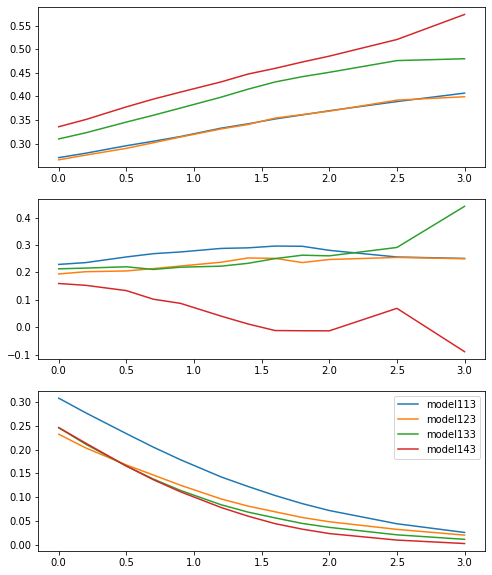

In [ ]:
if(True):
    fig, ax= pyplot.subplots(3,1, figsize=(8, 10))#sharex=True, 
    ax[0].plot(np.transpose(np.array([StdArr[0][:12],StdArr[1][:12],StdArr[2][:12],StdArr[3][:12]])),np.transpose(np.array([PrecTr[0][:12],PrecTr[1][:12],PrecTr[2][:12],PrecTr[3][:12]])))
    ax[1].plot(np.transpose(np.array([StdArr[0][:12],StdArr[1][:12],StdArr[2][:12],StdArr[3][:12]])),np.transpose(np.array([PrecTest[0][:12],PrecTest[1][:12],PrecTest[2][:12],PrecTest[3][:12]])))
    ax[2].plot(np.transpose(np.array([StdArr[0][:12],StdArr[1][:12],StdArr[2][:12],StdArr[3][:12]])),np.transpose(np.array([RecTest[0][:12],RecTest[1][:12],RecTest[2][:12],RecTest[3][:12]])))
    ax[2].legend(ModelNames)
    plt.show()

Сравнение сверточных и реккурентных

In [ ]:
custom_objects = {"my_loss_fn2": my_loss_fn2}
ModelNames=["model113","model123","model133","model143","model215_L5_80","model216_L5_80","model217_L5_80","model226_L5_80","model236_L5_80","model246_L5_80"]
Models=[]
for ModelName in ModelNames:
  with tf.keras.utils.custom_object_scope(custom_objects):
    Models.append(load_model(FileDir+ModelName+".h5"))

In [ ]:
#----------------------
import gc
InDataTrain=[x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4,x_data_train_t1,x_data_train_t1,x_data_train_t1,x_data_train_t2,x_data_train_t3,x_data_train_t4]
InDataTest=[x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4,x_data_test_t1,x_data_test_t1,x_data_test_t1,x_data_test_t2,x_data_test_t3,x_data_test_t4]
#Models=[model113,model123,model133,model143,model215,model216,model217,model226,model236,model246]

PrecTr=[]
RecTr=[]
PrecTest=[]
RecTest=[]
StdArr=[]
Borders=[0,0.2,0.5,0.7,0.9,1.2,1.4,1.6,1.8,2,2.5,3,4,5]
for i,Model in enumerate(Models):
  PrecTr.append([])
  RecTr.append([])
  PrecTest.append([])
  RecTest.append([])
  StdArr.append([])
  pred1=Model.predict(InDataTrain[i],verbose=0)
  pred2=Model.predict(InDataTest[i],verbose=0)
  std1=pred1.std(axis=0)
  mean1=pred1.mean(axis=0)
  for Border in Borders:
    Profit, Volume,VolumeBuy,VolumeSell, Recall, WinVolumeBuy, WinVolumeSell, LossVolumeBuy, LossVolumeSell=TradeResult(pred1,TemplTrPr,Border=std1*Border)
    Profit2, Volume2,VolumeBuy2,VolumeSell2, Recall2, WinVolumeBuy2, WinVolumeSell2, LossVolumeBuy2, LossVolumeSell2=TradeResult(pred2,TemplTestPr,Border=std1*Border)
    if(Volume>0 and Volume2>0):
      print(i,Border,"%Prof=",int(Profit/Volume*100)/100,int(Profit2/Volume2*100)/100,"rec=",int(Recall*1000)/1000,int(Recall2*1000)/1000,"---train---","Profit=",Profit,"Volume V B S=",Volume,VolumeBuy,VolumeSell,"Recall-", int(Recall*1000)/1000,"PFBuy=",WinVolumeBuy/LossVolumeBuy,"PFSell=",WinVolumeSell/LossVolumeSell,"PF=",(WinVolumeBuy+WinVolumeSell)/(LossVolumeBuy+LossVolumeSell),"---test---","Profit=",Profit2,"Volume V B S=",Volume2,VolumeBuy2,VolumeSell2,"Recall-", int(Recall*1000)/1000,"PFBuy=",WinVolumeBuy2/LossVolumeBuy2,"PFSell=",WinVolumeSell2/LossVolumeSell2,"PF=",(WinVolumeBuy2+WinVolumeSell2)/(LossVolumeBuy2+LossVolumeSell2),std1)
      PrecTr[i].append(Profit/Volume)
      PrecTest[i].append(Profit2/Volume2)
      RecTr[i].append(Recall)
      RecTest[i].append(Recall2)
      StdArr[i].append(Border)
    
    gc.collect()
  del pred1
  del pred2
  del Model


0 0 %Prof= 0.24 0.23 rec= 0.21 0.223 ---train--- Profit= 16706.182049000094 Volume V B S= 69010.14739699943 29736.67621200012 39273.4711850002 Recall- 0.21 PFBuy= 1.6229961581414238 PFSell= 1.650913494485138 PF= 1.6388112999787672 ---test--- Profit= 815.9865539999996 Volume V B S= 3483.8475319999966 1456.3695699999992 2027.4779619999983 Recall- 0.21 PFBuy= 1.3755329420269484 PFSell= 1.812582843083139 PF= 1.6117159482663261 [0.07531167 0.08738594 0.06786951]
0 0.2 %Prof= 0.24 0.24 rec= 0.182 0.196 ---train--- Profit= 14826.864520000005 Volume V B S= 59870.79550999962 25900.436097000103 33970.35941300026 Recall- 0.182 PFBuy= 1.644927864031061 PFSell= 1.6686383049960638 PF= 1.6583290664969577 ---test--- Profit= 743.7314870000004 Volume V B S= 3065.607426999995 1278.5085589999994 1787.0988679999984 Recall- 0.182 PFBuy= 1.3901533471553507 PFSell= 1.8546470118273022 PF= 1.640629823658882 [0.07531167 0.08738594 0.06786951]
0 0.5 %Prof= 0.25 0.25 rec= 0.144 0.163 ---train--- Profit= 12254.1068

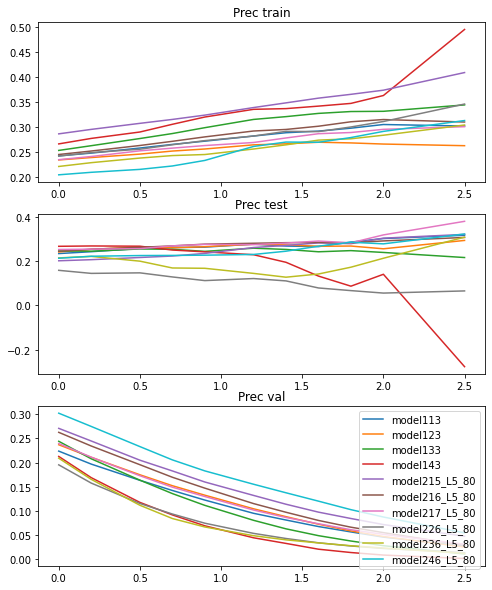

In [ ]:
if(True):
    fig, ax= pyplot.subplots(3,1, figsize=(8, 10))#sharex=True, 
    ax[0].plot(Borders[:11],np.transpose(np.array([PrecTr[i][:11] for i in range(len(PrecTr))])))
    ax[1].plot(Borders[:11],np.transpose(np.array([PrecTest[i][:11] for i in range(len(PrecTest))])))
    ax[2].plot(Borders[:11],np.transpose(np.array([RecTest[i][:11] for i in range(len(PrecTest))])))
    ax[2].legend(ModelNames)
    ax[0].set_title("Prec train")
    ax[1].set_title("Prec test")
    ax[2].set_title("Prec val")
    plt.show()

Сравнение реккурент

In [ ]:
#LSTM 16,8
import gc
InDataTrain=[x_data_train_t2,x_data_train_t2,x_data_train_t2,x_data_train_t3,x_data_train_t3,x_data_train_t3]
InDataTest=[x_data_test_t2,x_data_test_t2,x_data_test_t2,x_data_test_t3,x_data_test_t3,x_data_test_t3]
Models=[model123,model226,model228,model133,model236,model238]
ModelNames=["model123","model226","model228","model133","model236","model238"]
PrecTr=[]
RecTr=[]
PrecTest=[]
RecTest=[]
StdArr=[]
Borders=[0,0.2,0.5,0.7,0.9,1.2,1.4,1.6,1.8,2,2.5,3,4,5]
for i,Model in enumerate(Models):
  PrecTr.append([])
  RecTr.append([])
  PrecTest.append([])
  RecTest.append([])
  StdArr.append([])
  pred1=Model.predict(InDataTrain[i],verbose=0)
  pred2=Model.predict(InDataTest[i],verbose=0)
  std1=pred1.std(axis=0)
  mean1=pred1.mean(axis=0)
  for Border in Borders:
    Profit, Volume,VolumeBuy,VolumeSell, Recall, WinVolumeBuy, WinVolumeSell, LossVolumeBuy, LossVolumeSell=TradeResult(pred1,TemplTrPr,Border=std1*Border)
    Profit2, Volume2,VolumeBuy2,VolumeSell2, Recall2, WinVolumeBuy2, WinVolumeSell2, LossVolumeBuy2, LossVolumeSell2=TradeResult(pred2,TemplTestPr,Border=std1*Border)
    if(Volume>0 and Volume2>0):
      print(i,Border,"%Prof=",int(Profit/Volume*100)/100,int(Profit2/Volume2*100)/100,"rec=",int(Recall*1000)/1000,int(Recall2*1000)/1000,"---train---","Profit=",Profit,"Volume V B S=",Volume,VolumeBuy,VolumeSell,"Recall-", int(Recall*1000)/1000,"PFBuy=",WinVolumeBuy/LossVolumeBuy,"PFSell=",WinVolumeSell/LossVolumeSell,"PF=",(WinVolumeBuy+WinVolumeSell)/(LossVolumeBuy+LossVolumeSell),"---test---","Profit=",Profit2,"Volume V B S=",Volume2,VolumeBuy2,VolumeSell2,"Recall-", int(Recall*1000)/1000,"PFBuy=",WinVolumeBuy2/LossVolumeBuy2,"PFSell=",WinVolumeSell2/LossVolumeSell2,"PF=",(WinVolumeBuy2+WinVolumeSell2)/(LossVolumeBuy2+LossVolumeSell2),std1)
      PrecTr[i].append(Profit/Volume)
      PrecTest[i].append(Profit2/Volume2)
      RecTr[i].append(Recall)
      RecTest[i].append(Recall2)
      StdArr[i].append(Border)
    
    gc.collect()
  del pred1
  del pred2
  del Model

0 0 %Prof= 0.27 0.17 rec= 0.229 0.212 ---train--- Profit= 17409.720903000067 Volume V B S= 63348.7894429997 33420.530221999856 29928.259221000204 Recall- 0.229 PFBuy= 1.6796238651482345 PFSell= 1.8510063929389449 PF= 1.7579483631820245 ---test--- Profit= 2555.4481850000034 Volume V B S= 14357.781081000068 8257.952386999994 6099.828693999976 Recall- 0.229 PFBuy= 1.5027696624644928 PFSell= 1.3446082210725598 PF= 1.433041197451069 [0.10016974 0.11203321 0.08643067]
0 0.2 %Prof= 0.28 0.18 rec= 0.2 0.185 ---train--- Profit= 15745.095257999983 Volume V B S= 55262.5912119997 29676.060353999925 25586.53085800024 Recall- 0.2 PFBuy= 1.7195229366262885 PFSell= 1.8922714609947031 PF= 1.79686705232172 ---test--- Profit= 2304.9891500000067 Volume V B S= 12534.48546000005 7407.712666999997 5126.772792999986 Recall- 0.2 PFBuy= 1.5260381264430378 PFSell= 1.3493529999962472 PF= 1.450655453631033 [0.10016974 0.11203321 0.08643067]
0 0.5 %Prof= 0.3 0.18 rec= 0.16 0.149 ---train--- Profit= 13430.3035130000

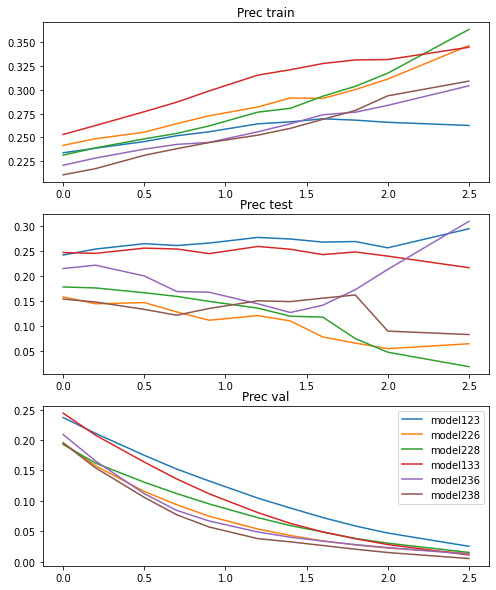

In [ ]:
if(True):
    fig, ax= pyplot.subplots(3,1, figsize=(8, 10))#sharex=True, 
    ax[0].plot(Borders[:11],np.transpose(np.array([PrecTr[i][:11] for i in range(len(PrecTr))])))
    ax[1].plot(Borders[:11],np.transpose(np.array([PrecTest[i][:11] for i in range(len(PrecTest))])))
    ax[2].plot(Borders[:11],np.transpose(np.array([RecTest[i][:11] for i in range(len(PrecTest))])))
    ax[2].legend(ModelNames)
    ax[0].set_title("Prec train")
    ax[1].set_title("Prec test")
    ax[2].set_title("Prec val")
    plt.show()